In [19]:
%matplotlib inline

import pickle
import pandas as pd
from pandas import Series
from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from collections import defaultdict 
from itertools import combinations


import torch
from sentence_transformers import models, SentenceTransformer
from sentence_transformers import InputExample
from sentence_transformers import losses
from torch.utils.data import DataLoader
from sentence_transformers.evaluation import TripletEvaluator

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

## Generation of belief triplets

### Read dataset 

In [4]:
df = pd.read_pickle('../dataset/01_Final_dataframe/df_ddo_including_only_truebeliefs_nodup(N192307).p')

In [6]:
df.head()

debate_key  \
1  .-Audis-are-junkers-except-to-rich-kids-with-l...   
2  ....-Former-Secretary-of-State-Madeleine-Albri...   
3                     ...Words-can-t-hurt-me-any./1/   
4                      .9-repeated-is-equal-to-1./1/   
5                            .99-is-equal-to-one./1/   

                                        debate_title          username  \
1  . Audis are junkers, except to rich kids with ...       Max.Wallace   
2  ...."Former Secretary of State Madeleine Albri...   Lookingatissues   
3                        ...Words can't hurt me any.      NonInDelicto   
4                         .9 repeated is equal to 1.        cowpie1998   
5                               .99 is equal to one.  SweetCrackerJack   

  debate_date position  is_belief  \
1  2014-09-04      Pro        1.0   
2  2017-01-30      Pro        1.0   
3  2007-12-19      Pro        1.0   
4  2011-04-07      Pro        1.0   
5  2013-12-24      Pro        1.0   

                                    belief_statement  
1  I agree with the following: . Audis are junker...  
2  I agree with the following: ...."Former Secret...  
3  I agree with the following: ...Words can't hur...  
4  I agree with the following: .9 repeated is equ...  
5   I agree with the following: .99 is equal to one.

In [5]:
print('data size:', len(df))
print('num debates:', len(df['debate_key'].unique()))
print('num debate title:', len(df['debate_title'].unique()))
print('num users:', len(df['username'].unique()))
print('average participation:', len(df)/len(df['username'].unique())  )
print('Unique beliefs', len(df['belief_statement'].unique()))

data size: 192307
num debates: 65861
num debate title: 59986
num users: 40280
average participation: 4.7742552135054614
Unique beliefs 119972


### Generate 5-fold dataset

In [8]:
debate_titles = df.debate_title.unique()
print(f"There are {len(debate_titles)} unique debates in debate.org dataset")

There are 59986 unique debates in debate.org dataset


In [9]:
kf = KFold(n_splits=5)
kf.get_n_splits(debate_titles)

5

In [10]:
train_indices = []
test_indices  = []

for i, (train_index, test_index) in enumerate(kf.split(debate_titles)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")  
    print(f"  Test:  index={test_index}")    
    print(len(train_index), len(test_index))

    train_indices.append(train_index)
    test_indices.append(test_index)

Fold 0:
  Train: index=[11998 11999 12000 ... 59983 59984 59985]
  Test:  index=[    0     1     2 ... 11995 11996 11997]
47988 11998
Fold 1:
  Train: index=[    0     1     2 ... 59983 59984 59985]
  Test:  index=[11998 11999 12000 ... 23992 23993 23994]
47989 11997
Fold 2:
  Train: index=[    0     1     2 ... 59983 59984 59985]
  Test:  index=[23995 23996 23997 ... 35989 35990 35991]
47989 11997
Fold 3:
  Train: index=[    0     1     2 ... 59983 59984 59985]
  Test:  index=[35992 35993 35994 ... 47986 47987 47988]
47989 11997
Fold 4:
  Train: index=[    0     1     2 ... 47986 47987 47988]
  Test:  index=[47989 47990 47991 ... 59983 59984 59985]
47989 11997


In [ ]:
for i in range(5):
    
    train_titles = debate_titles[train_indices[i]]
    test_titles = debate_titles[test_indices[i]]
    df_train = df[df['debate_title'].isin(train_titles)]
    df_test  = df[df['debate_title'].isin(test_titles)]
        
    df_train.to_pickle('../dataset/04_K-fold_dataset/df_train_idx%d.p'%(i))
    df_test.to_pickle('../dataset/04_K-fold_dataset/df_test_idx%d.p'%(i))
    
    #print("Train size:",len(df_train), "Test size:",len(df_test))

### Generate triplets

In [12]:
pro_phrase = 'I agree with the following: '
con_phrase = 'I disagree with the following: '

def get_reverse_phrase(phrase):
    if phrase == pro_phrase:
        return con_phrase
    elif phrase == con_phrase:
        return pro_phrase
    else: 
        print('error')
        
def get_opposite_belief(belief_statement):
    position = " ".join(belief_statement.split()[:5]) + ' '
    title = " ".join(belief_statement.split()[5:]) 
    
    position_r = get_reverse_phrase(position)
    opposite_belief = position_r + title
    return opposite_belief        

In [13]:
#example 
get_opposite_belief('I agree with the following: apples are delicious.')

'I disagree with the following: apples are delicious.'

In [14]:
#get a belief co-occurrence dictionary
def get_belief_cooccurrence_dic(df):
    
    df_g = df.groupby('username')
    corpus = []

    for g, data in df_g:

        data = data.sort_values(by='debate_date')
        user_beliefs = list(data['belief_statement'].unique())
        corpus.append(user_beliefs)
        
    
    belief2list = defaultdict(list)
    
    for b_list in corpus:
        if len(b_list) == 1: 
            continue

        for e1 in b_list:
            for e2 in b_list:
                if e1 != e2:
                    belief2list[e1].append(e2)
                    
    return belief2list

In [15]:
dic_co = get_belief_cooccurrence_dic(df)

In [16]:
len(dic_co)

102881

In [17]:
#Get triplets using the belief co-occurrence dictionary
def get_stance_triplet(belief2list):
    
    belief_triplet = []

    for s in tqdm(belief2list):

        anchor = s
        positive_samples = belief2list[s] 
        opposite_belief = get_opposite_belief(s)

        if not opposite_belief in belief2list: #use only direct opposite stance as a negative sample
            negative_samples = [opposite_belief]
        else:
            negative_samples = [opposite_belief] + belief2list[opposite_belief]

        #if vote history is too long: Sample 5 stances from history 
        thres = 5
        if len(positive_samples) > thres-1:
            positive_samples = np.random.choice(positive_samples, size=thres, replace=False)

        if len(negative_samples) > thres-1:
            #to ensure including directly opposite stance
            other_samples = np.random.choice(negative_samples[1:], size=thres-1, replace=False)        
            negative_samples = np.concatenate((negative_samples[:1], other_samples)) 

        #make triplet examples 
        for pos in positive_samples:
            for neg in negative_samples:
                example = [anchor, pos, neg]
                belief_triplet.append(example)
    
    return belief_triplet

In [ ]:
for i in tqdm(range(5)):
    df_train = pd.read_pickle('../dataset/04_K-fold_dataset/df_train_idx%d.p'%(i))
    df_test = pd.read_pickle('../dataset/04_K-fold_dataset/df_test_idx%d.p'%(i))

    belief2list_train = get_belief_cooccurrence_dic(df_train)
    belief2list_test  = get_belief_cooccurrence_dic(df_test)
    
    train_triplets = get_stance_triplet(belief2list_train)
    test_triplets  = get_stance_triplet(belief2list_test)
    
    with open('../dataset/04_K-fold_triplets/train_triplet_idx%d.p'%i,'wb') as f:
        pickle.dump(train_triplets, f)
        
    with open('../dataset/04_K-fold_triplets/test_triplet_idx%d.p'%i,'wb') as f:
        pickle.dump(test_triplets, f)

## Train / Test set with commonly appearing users

In [21]:
train_sets = []
test_sets  = []

BASE_PATH = '../dataset/04_K-fold_dataset/'

for i in range(5):    
    
    df_train = pd.read_pickle(BASE_PATH + 'df_train_idx%d.p'%(i))
    df_test  = pd.read_pickle(BASE_PATH + 'df_test_idx%d.p'%(i))
        
    train_users = df_train.username.unique()
    test_users  = df_test.username.unique()
    
    common_users = []
    for u in test_users:
        if u in train_users:
            common_users.append(u)
    
    df_train_common = df_train[df_train['username'].isin(common_users)]
    df_test_common  = df_test[df_test['username'].isin(common_users)]
    
    
    train_sets.append(df_train_common)
    test_sets.append(df_test_common)
    
    print("Dataset idx:%d"%(i))
    print("# votes: Train, Train_common, Test, Test_common")
    print(len(df_train), len(df_train_common), len(df_test), len(df_test_common))
    print("# voters: Train, Train_common, Test, Test_common")
    print(len(df_train.username.unique()), len(df_train_common.username.unique()), len(df_test.username.unique()), len(df_test_common.username.unique()))
    print()

Dataset idx:0
# votes: Train, Train_common, Test, Test_common
153698 111724 38609 33208
# voters: Train, Train_common, Test, Test_common
35447 10173 15006 10173

Dataset idx:1
# votes: Train, Train_common, Test, Test_common
151618 110860 40689 35171
# voters: Train, Train_common, Test, Test_common
35362 10401 15319 10401

Dataset idx:2
# votes: Train, Train_common, Test, Test_common
151524 107163 40783 36060
# voters: Train, Train_common, Test, Test_common
36092 9706 13894 9706

Dataset idx:3
# votes: Train, Train_common, Test, Test_common
157602 113625 34705 27733
# voters: Train, Train_common, Test, Test_common
34205 9675 15750 9675

Dataset idx:4
# votes: Train, Train_common, Test, Test_common
154786 110227 37521 33007
# voters: Train, Train_common, Test, Test_common
36220 9744 13804 9744



In [ ]:
BASE_PATH = '../dataset/04_K-fold_dataset_commonusers/'

for i in range(5):    
    
    train_sets[i].to_pickle(BASE_PATH + 'df_commonuser_train_idx%d.p'%(i))
    test_sets[i].to_pickle(BASE_PATH + 'df_commonuser_test_idx%d.p'%(i))

## Fine-tuing Sentence-BERT model

### Training S-BERT

In [ ]:
for data_index in range(5): #iteration over K-fold 

    #Load dataset 
    filepath = '../dataset/04_K-fold_triplets/train_triplet_idx%d.p'%(data_index) 

    with open(filepath,'rb') as f:
        triplet_data = pickle.load(f)

    #Make InputExamples to use it as input for Data loader 
    triplets = []
    for e in tqdm(triplet_data):
        triplets.append(InputExample(texts = e))

    #Data Loader 
    batch_size = 32
    loader = DataLoader(triplets, shuffle=True, batch_size=batch_size)    
   
    num_epochs = 5
    for epoch in range(num_epochs):
        
        print("Dataidx: %d, epoch: %d"%(data_index, epoch))
        
        if epoch == 0:
            model = SentenceTransformer('roberta-base-nli-stsb-mean-tokens')        
        else:
            model = SentenceTransformer('../model/roberta-base_idx%d_epoch%d'%(data_index, epoch))
            
        device = "cuda:0" if torch.cuda.is_available() else "cpu"
        model.to(device)

        loss = losses.TripletLoss(model)
        savepath = '../model/roberta-base_idx%d_epoch%d'%(data_index, epoch+1)
        
        model.fit(
            train_objectives=[(loader, loss)],
            epochs=1,
            output_path=savepath,
            show_progress_bar=True
        )


### Training original-BERT

In [ ]:
for data_index in range(5): 

    #Load dataset 
    filepath = '../dataset/04_K-fold_triplets/train_triplet_idx%d.p'%(data_index) 

    with open(filepath,'rb') as f:
        triplet_data = pickle.load(f)

    print(f"Total # tripliets : {len(triplet_data)}")

    
    #Make InputExamples to use it as input for Data loader 
    triplets = []
    for e in tqdm(triplet_data):
        triplets.append(InputExample(texts = e))

    #Data Loader 
    batch_size = 32
    loader = DataLoader(triplets, shuffle=True, batch_size=batch_size)    


    #Model preparation - BERT 
    bert = models.Transformer('bert-base-uncased')

    pooler = models.Pooling(
                bert.get_word_embedding_dimension(), #768
                    pooling_mode_mean_tokens=True #mean pooling
                    )
    model = SentenceTransformer(modules=[bert, pooler])

    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    model.to(device)
    print("device: ", model.device)


    #Train model 
    loss = losses.TripletLoss(model)
    epochs = 5
    
    for epoch in range(epochs):
        
        savepath = '../model/finetuned-BERT_idx%d_epoch%d'%(data_index, epoch+1)
        
        model.fit(
            train_objectives=[(loader, loss)],
            epochs=1,
            output_path=savepath,
            show_progress_bar=True
        )

## Triplet Evaluation 

### BASE S-BERT without fine-tuning 

In [ ]:
for foldidx in range(5):

    #Train set
    filepath = '../dataset/04_K-fold_triplets/train_triplet_idx%d.p'%(foldidx)

    with open(filepath,'rb') as f:
        triplet_data = pickle.load(f)

    triplet_data = pd.Series(triplet_data)
    triplet_data = triplet_data.sample(100000, random_state=99).to_list()
    
    train_samples = []
    for e in tqdm(triplet_data):
        train_samples.append(InputExample(texts = e))

    model = SentenceTransformer('roberta-base-nli-stsb-mean-tokens')    

    #Evaluator, using train samples
    triplet_evaluator = TripletEvaluator.from_input_examples(
        train_samples,
        write_csv=True,
        show_progress_bar=True,
        name = 'roberta-base_untrained_(trainset)idx%d'%(foldidx)
    )

    output_path = '../eval/'
    triplet_evaluator(model, output_path=output_path)

    #Test set
    filepath = '../dataset/04_K-fold_triplets/test_triplet_idx%d.p'%(foldidx)

    with open(filepath,'rb') as f:
        triplet_data = pickle.load(f)

    triplet_data = pd.Series(triplet_data)
    triplet_data = triplet_data.sample(100000, random_state=99).to_list()
    
    test_samples = []
    for e in tqdm(triplet_data):
        test_samples.append(InputExample(texts = e))

    model = SentenceTransformer('roberta-base-nli-stsb-mean-tokens')    

    #Evaluator, using train samples
    triplet_evaluator = TripletEvaluator.from_input_examples(
        test_samples,
        write_csv=True,
        show_progress_bar=True,
        name = 'roberta-base_untrained_(testset)idx%d'%(foldidx)
    )

    output_path = '../eval/'
    triplet_evaluator(model, output_path=output_path)

### Base BERT (without finetuing)

In [ ]:
#BASE BERT 
for foldidx in range(5):

    print(foldidx)
    
    #Train set
    filepath = '../dataset/04_K-fold_triplets/train_triplet_idx%d.p'%(foldidx)

    with open(filepath,'rb') as f:
        triplet_data = pickle.load(f)

    triplet_data = pd.Series(triplet_data)
    triplet_data = triplet_data.sample(100000, random_state=99).to_list()
    
    train_samples = []
    for e in tqdm(triplet_data):
        train_samples.append(InputExample(texts = e))

    bert = models.Transformer('bert-base-uncased')

    pooler = models.Pooling(
        bert.get_word_embedding_dimension(), #768
        pooling_mode_mean_tokens=True #mean pooling
    )
    model = SentenceTransformer(modules=[bert, pooler])

    #Evaluator, using train samples
    triplet_evaluator = TripletEvaluator.from_input_examples(
        train_samples,
        write_csv=True,
        show_progress_bar=True,
        name = 'bert_untrained_(trainset)_idx%d'%(foldidx)
    )

    output_path = '../eval/'
    triplet_evaluator(model, output_path=output_path)


    #Test set
    print(foldidx)
    filepath = '../dataset/04_K-fold_triplets/test_triplet_idx%d.p'%(foldidx)

    with open(filepath,'rb') as f:
        triplet_data = pickle.load(f)

    triplet_data = pd.Series(triplet_data)
    triplet_data = triplet_data.sample(100000, random_state=99).to_list()
    
    test_samples = []
    for e in tqdm(triplet_data):
        test_samples.append(InputExample(texts = e))

    bert = models.Transformer('bert-base-uncased')

    pooler = models.Pooling(
        bert.get_word_embedding_dimension(), #768
        pooling_mode_mean_tokens=True #mean pooling
    )
    model = SentenceTransformer(modules=[bert, pooler])

    #Evaluator, using train samples
    triplet_evaluator = TripletEvaluator.from_input_examples(
        test_samples,
        write_csv=True,
        show_progress_bar=True,
        name = 'bert_untrained_(testset)_idx%d'%(foldidx)
    )

    output_path = '../eval/'
    triplet_evaluator(model, output_path=output_path)
    


### Finetuned S-BERT triplet evaluation

In [ ]:
data_index_list = [0,1,2,3,4]
epochs = [1,2,3,4,5]

for data_index in data_index_list:
    for epoch in epochs:

        print("data idx:", data_index, 'epoch', epoch)

        #TRAIN DATSET
        filepath = '../dataset/04_K-fold_triplets/train_triplet_idx%d.p'%(data_index) 

        with open(filepath,'rb') as f:
            triplet_data = pickle.load(f)

        triplet_data = pd.Series(triplet_data)
        triplet_data = triplet_data.sample(100000, random_state=99).to_list()
        
        train_samples = []
        for e in tqdm(triplet_data):
            train_samples.append(InputExample(texts = e))

        #Test DATSET
        filepath = '../dataset/04_K-fold_triplets/test_triplet_idx%d.p'%(data_index) 

        with open(filepath,'rb') as f:
            triplet_data = pickle.load(f)

        triplet_data = pd.Series(triplet_data)
        triplet_data = triplet_data.sample(100000, random_state=99).to_list()
        
        test_samples = []
        for e in tqdm(triplet_data):
            test_samples.append(InputExample(texts = e))

            
        #Load model 
        modelpath = '../model/roberta-base_idx%d_epoch%d'%(data_index, epoch)
        model = SentenceTransformer(modelpath)    

        #Evaluate using train samples
        triplet_evaluator = TripletEvaluator.from_input_examples(
            train_samples,
            write_csv=True,
            show_progress_bar=True,
            name = 'roberta-base-Train_idx%d_epoch%d'%(data_index, epoch)
        )
        output_path = '../eval/'
        triplet_evaluator(model, output_path=output_path)

        #Evaluate using test samples
        triplet_evaluator = TripletEvaluator.from_input_examples(
            test_samples,
            write_csv=True,
            show_progress_bar=True,
            name = 'roberta-base-Test_idx%d_epoch%d'%(data_index, epoch)
        )
        output_path = '../eval/'
        triplet_evaluator(model, output_path=output_path)




### Finetuned BERT triplet evaluation

In [ ]:
data_index_list = [0,1,2,3,4]
epochs = [1,2,3,4,5]

for data_index in data_index_list:
    for epoch in epochs:

        print("data idx:", data_index, 'epoch', epoch)

        #TRAIN DATSET
        filepath = '../dataset/04_K-fold_triplets/train_triplet_idx%d.p'%(data_index) 

        with open(filepath,'rb') as f:
            triplet_data = pickle.load(f)

        triplet_data = pd.Series(triplet_data)
        triplet_data = triplet_data.sample(100000, random_state=99).to_list()
        
        train_samples = []
        for e in tqdm(triplet_data):
            train_samples.append(InputExample(texts = e))

        #Test DATSET
        filepath = '../dataset/04_K-fold_triplets/test_triplet_idx%d.p'%(data_index) 

        with open(filepath,'rb') as f:
            triplet_data = pickle.load(f)

        triplet_data = pd.Series(triplet_data)
        triplet_data = triplet_data.sample(100000, random_state=99).to_list()
        
        test_samples = []
        for e in tqdm(triplet_data):
            test_samples.append(InputExample(texts = e))

            
        #Load finetuned-BERT model 
        modelpath = '../model/finetuned-BERT_idx%d_epoch%d'%(data_index, epoch)
        model = SentenceTransformer(modelpath)    

        #Evaluate using train samples
        triplet_evaluator = TripletEvaluator.from_input_examples(
            train_samples,
            write_csv=True,
            show_progress_bar=True,
            name = 'finetuned-BERT-Train_idx%d_epoch%d'%(data_index, epoch)
        )
        output_path = '../eval/'
        triplet_evaluator(model, output_path=output_path)

        #Evaluate using test samples
        triplet_evaluator = TripletEvaluator.from_input_examples(
            test_samples,
            write_csv=True,
            show_progress_bar=True,
            name = 'finetuned-BERT-Test_idx%d_epoch%d'%(data_index, epoch)
        )
        output_path = '../eval/'
        triplet_evaluator(model, output_path=output_path)

## Evaluation result 

### BERT-finetuned

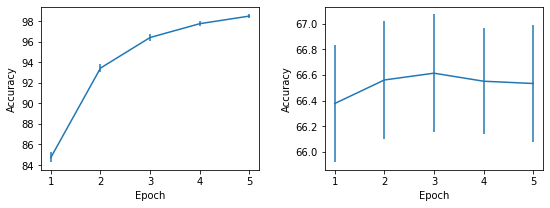

In [23]:
model_type = 'finetuned-BERT'
data_type_list = ['Train', 'Test']
data_index_list = [0,1,2,3,4]

figs, axes = plt.subplots(1,2, figsize=(9,3))

acc_cos_over_epochs = {}
std_cos_over_epochs = {}
acc_euc_over_epochs = {}
std_euc_over_epochs = {}

for tid, data_type in enumerate(data_type_list):    

    acc_cos_over_epochs[data_type] = []
    std_cos_over_epochs[data_type] = []
    acc_euc_over_epochs[data_type] = []
    std_euc_over_epochs[data_type] = []
    
    for epoch in range(1,6):
        
        acc_cosine = []
        acc_euclid = []

        for data_index in data_index_list:
            filepath = '../eval/triplet_evaluation_%s-%s_idx%d_epoch%d_results.csv'%(model_type, data_type, data_index, epoch)
            df = pd.read_csv(filepath)
            
            acc_cosine.append(df['accuracy_cosinus'][0])
            acc_euclid.append(df['accuracy_euclidean'][0])    

        acc_cos_over_epochs[data_type].append(np.mean(acc_cosine)*100)
        acc_euc_over_epochs[data_type].append(np.mean(acc_euclid)*100)
        std_cos_over_epochs[data_type].append(np.std(acc_cosine)*100)
        std_euc_over_epochs[data_type].append(np.std(acc_euclid)*100)

        #print("Model : %5s, %5s, Acc_cosine : %.2f%%, Acc_eulidean : %.2f%%"%(model_type, data_type, np.mean(acc_cosine)*100, np.mean(acc_euclid)*100))
        #print("Model : %5s, %5s, std_cosine : %.3f, std_eulidean : %.3f"%(model_type, data_type, np.std(acc_cosine)*100, np.std(acc_euclid)*100))

    axes[tid].errorbar(x=np.arange(1,6), y=acc_euc_over_epochs[data_type], yerr=std_euc_over_epochs[data_type])
    axes[tid].set_xlabel('Epoch')
    axes[tid].set_ylabel('Accuracy')

plt.subplots_adjust(wspace=0.3)
#plt.savefig('../fig/Triplet_loss_(BERT).pdf', transparent=True, bbox_inches='tight')
    

### S-BERT( roberta-base-nli-stsb-mean-tokens) finetuned

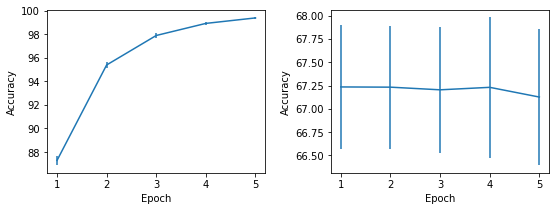

In [25]:
data_type_list = ['Train', 'Test']
data_index_list = [0,1,2,3,4]

figs, axes = plt.subplots(1,2, figsize=(9,3))

acc_cos_over_epochs_sb = {}
std_cos_over_epochs_sb = {}
acc_euc_over_epochs_sb = {}
std_euc_over_epochs_sb = {}

for tid, data_type in enumerate(data_type_list):

    acc_cos_over_epochs_sb[data_type] = []
    std_cos_over_epochs_sb[data_type] = []
    acc_euc_over_epochs_sb[data_type] = []
    std_euc_over_epochs_sb[data_type] = []
    
    for epoch in range(1,6):
        
        acc_cosine = []
        acc_euclid = []

        for data_index in data_index_list:
            filepath = '../eval/triplet_evaluation_roberta-base-%s_idx%d_epoch%d_results.csv'%(data_type, data_index, epoch)
            df = pd.read_csv(filepath)
            
            acc_cosine.append(df['accuracy_cosinus'][0])
            acc_euclid.append(df['accuracy_euclidean'][0])    

        acc_cos_over_epochs_sb[data_type].append(np.mean(acc_cosine)*100)
        acc_euc_over_epochs_sb[data_type].append(np.mean(acc_euclid)*100)
        std_cos_over_epochs_sb[data_type].append(np.std(acc_cosine)*100)
        std_euc_over_epochs_sb[data_type].append(np.std(acc_euclid)*100)

        #print("Model : %5s, %5s, Acc_cosine : %.2f%%, Acc_eulidean : %.2f%%"%(model_type, data_type, np.mean(acc_cosine)*100, np.mean(acc_euclid)*100))
        #print("Model : %5s, %5s, std_cosine : %.3f, std_eulidean : %.3f"%(model_type, data_type, np.std(acc_cosine)*100, np.std(acc_euclid)*100))

    axes[tid].errorbar(x=np.arange(1,6), y=acc_euc_over_epochs_sb[data_type], yerr=std_euc_over_epochs_sb[data_type])
    axes[tid].set_xlabel('Epoch')
    axes[tid].set_ylabel('Accuracy')

plt.subplots_adjust(wspace=0.3)
#plt.savefig('../fig/Triplet_loss_(S-BERT).pdf', transparent=True, bbox_inches='tight')


### Base model (BERT, S-BERT)

In [26]:
model_type = 'base BERT'
data_type_list = ['trainset', 'testset']
data_index_list = [0,1,2,3,4]

acc_cos_over_epochs_base_bert = {}
std_cos_over_epochs_base_bert = {}
acc_euc_over_epochs_base_bert = {}
std_euc_over_epochs_base_bert = {}

for tid, data_type in enumerate(data_type_list):    

    acc_cos_over_epochs_base_bert[data_type] = []
    std_cos_over_epochs_base_bert[data_type] = []
    acc_euc_over_epochs_base_bert[data_type] = []
    std_euc_over_epochs_base_bert[data_type] = []
    
    acc_cosine = []
    acc_euclid = []

    for data_index in data_index_list:
        filepath = '../eval/triplet_evaluation_bert_untrained_(%s)_idx%d_results.csv'%(data_type, data_index)
        df = pd.read_csv(filepath)
        
        acc_cosine.append(df['accuracy_cosinus'][0])
        acc_euclid.append(df['accuracy_euclidean'][0])    

    acc_cos_over_epochs_base_bert[data_type].append(np.mean(acc_cosine)*100)
    acc_euc_over_epochs_base_bert[data_type].append(np.mean(acc_euclid)*100)
    std_cos_over_epochs_base_bert[data_type].append(np.std(acc_cosine)*100)
    std_euc_over_epochs_base_bert[data_type].append(np.std(acc_euclid)*100)

        #print("Model : %5s, %5s, Acc_cosine : %.2f%%, Acc_eulidean : %.2f%%"%(model_type, data_type, np.mean(acc_cosine)*100, np.mean(acc_euclid)*100))
        #print("Model : %5s, %5s, std_cosine : %.3f, std_eulidean : %.3f"%(model_type, data_type, np.std(acc_cosine)*100, np.std(acc_euclid)*100))

print(acc_cos_over_epochs_base_bert)

{'trainset': [37.7008], 'testset': [35.907799999999995]}


In [27]:
print("%.3f"%acc_euc_over_epochs_base_bert['trainset'][0])
print("%.3f"%std_euc_over_epochs_base_bert['trainset'][0])
print("%.3f"%acc_euc_over_epochs_base_bert['testset'][0])
print("%.3f"%std_euc_over_epochs_base_bert['testset'][0])

37.669
0.212
35.890
0.774


In [28]:
#S-BERT
model_type = 'roberta-base'
data_type_list = ['trainset', 'testset']
data_index_list = [0,1,2,3,4]

acc_cos_over_epochs_base_sbert = {}
std_cos_over_epochs_base_sbert = {}
acc_euc_over_epochs_base_sbert = {}
std_euc_over_epochs_base_sbert = {}

for tid, data_type in enumerate(data_type_list):    

    acc_cos_over_epochs_base_sbert[data_type] = []
    std_cos_over_epochs_base_sbert[data_type] = []
    acc_euc_over_epochs_base_sbert[data_type] = []
    std_euc_over_epochs_base_sbert[data_type] = []
    
    acc_cosine = []
    acc_euclid = []

    for data_index in data_index_list:
        filepath = '../eval/triplet_evaluation_roberta-base_untrained_(%s)idx%d_results.csv'%(data_type, data_index)
        df = pd.read_csv(filepath)
        
        acc_cosine.append(df['accuracy_cosinus'][0])
        acc_euclid.append(df['accuracy_euclidean'][0])    

    acc_cos_over_epochs_base_sbert[data_type].append(np.mean(acc_cosine)*100)
    acc_euc_over_epochs_base_sbert[data_type].append(np.mean(acc_euclid)*100)
    std_cos_over_epochs_base_sbert[data_type].append(np.std(acc_cosine)*100)
    std_euc_over_epochs_base_sbert[data_type].append(np.std(acc_euclid)*100)

        #print("Model : %5s, %5s, Acc_cosine : %.2f%%, Acc_eulidean : %.2f%%"%(model_type, data_type, np.mean(acc_cosine)*100, np.mean(acc_euclid)*100))
        #print("Model : %5s, %5s, std_cosine : %.3f, std_eulidean : %.3f"%(model_type, data_type, np.std(acc_cosine)*100, np.std(acc_euclid)*100))

print(acc_cos_over_epochs_base_sbert)

{'trainset': [39.83519999999999], 'testset': [38.1918]}


In [29]:
print("%.3f"%acc_euc_over_epochs_base_sbert['trainset'][0])
print("%.3f"%std_euc_over_epochs_base_sbert['trainset'][0])
print("%.3f"%acc_euc_over_epochs_base_sbert['testset'][0])
print("%.3f"%std_euc_over_epochs_base_sbert['testset'][0])

39.832
0.194
38.111
1.010


### Aggregated result 

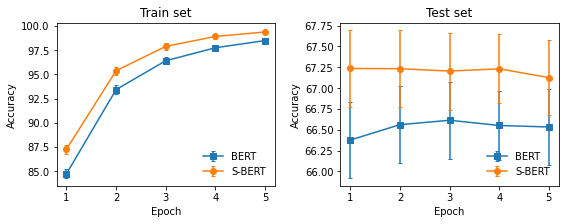

In [31]:
figs, axes = plt.subplots(1,2, figsize=(9,3))

ax1 = axes[0]
ax1.errorbar(np.arange(1,6), acc_euc_over_epochs['Train'], std_euc_over_epochs['Train'], fmt='s-', capsize=2, label='BERT')
ax1.errorbar(np.arange(1,6), acc_euc_over_epochs_sb['Train'], std_euc_over_epochs['Train'], fmt='o-', capsize=2, label='S-BERT')
#ax1.axhline(acc_euc_over_epochs_base_bert['trainset'][0], ls='--')
#ax1.axhline(acc_euc_over_epochs_base_sbert['trainset'][0], ls='--', color='orange')
ax1.legend(frameon=False, loc=4)
ax1.set_title('Train set')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')


ax2 = axes[1]
ax2.errorbar(np.arange(1,6), acc_euc_over_epochs['Test'], std_euc_over_epochs['Test'], fmt='s-', capsize=2, label='BERT')
ax2.errorbar(np.arange(1,6), acc_euc_over_epochs_sb['Test'], std_euc_over_epochs['Test'], fmt='o-', capsize=2, label='S-BERT')
#ax2.axhline(acc_euc_over_epochs_base_bert['testset'][0], ls='--')
#ax2.axhline(acc_euc_over_epochs_base_sbert['testset'][0], ls='--', color='orange')
#ax2.set_ylim(65,68)
ax2.set_title('Test set')
ax2.legend(frameon=False, loc=4)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')

plt.subplots_adjust(wspace=0.3)
#plt.savefig('../fig/Triplet_loss_(BERT_vs_S-BERT).pdf', transparent=True, bbox_inches='tight')

## Sentence textual similarity (STS) evaluation 

In [1]:
import datasets
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator

In [2]:
sts = datasets.load_dataset('glue', 'stsb', split='validation')

Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

In [7]:
sts = datasets.load_dataset('glue', 'stsb', split='validation')
sts = sts.map(lambda x: {'label': x['label'] / 5.0})

samples = []
for sample in sts:
    samples.append(InputExample(
      texts = [sample['sentence1'], sample['sentence2']],
      label = sample['label']
    ))
    
embedding_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(
    samples, write_csv=False
)

### BERT, S-BERT, (base models, and fine-tuned models) evaluation

In [8]:
bert = models.Transformer('bert-base-uncased')

pooler = models.Pooling(
    bert.get_word_embedding_dimension(), #768
    pooling_mode_mean_tokens=True #mean pooling
)
model1 = SentenceTransformer(modules=[bert, pooler])

embedding_evaluator(model1)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

0.6146284960227489

In [9]:
base_sbert = SentenceTransformer('roberta-base-nli-stsb-mean-tokens')    
embedding_evaluator(base_sbert)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/688 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/334 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

0.8770375704453881

In [ ]:
data_index_list = [0,1,2,3,4]
sts_over_epochs_bert = []
sts_over_epochs_std_bert = []

for epoch in range(1,6,1):

    sts_result = []

    for data_index in data_index_list:
        
        #Load model 
        modelpath = '../model/finetuned-BERT_idx%d_epoch%d'%(data_index, epoch)
        model = SentenceTransformer(modelpath)    
        
        score = embedding_evaluator(model)
        #print(score)
        sts_result.append(score)

    sts_over_epochs_bert.append(np.mean(sts_result))
    sts_over_epochs_std_bert.append(np.std(sts_result))
    
print("%.3f, (%.3f)"%(np.mean(sts_over_epochs_bert), np.std(sts_result)))    

In [ ]:
data_index_list = [0,1,2,3,4]
sts_over_epochs = []
sts_over_epochs_std = []

for epoch in range(1,6,1):

    sts_result = []
    
    for data_index in data_index_list:
        
        #Load model 
        modelpath = '../model/roberta-base_idx%d_epoch%d'%(data_index, epoch)
        model = SentenceTransformer(modelpath)    
            
        score = embedding_evaluator(model)
        #print(score)
        sts_result.append(score)

    sts_over_epochs.append(np.mean(sts_result))
    sts_over_epochs_std.append(np.std(sts_result))

In [ ]:
plt.figure(figsize=(4,3))
plt.errorbar(np.arange(1,6,1), sts_over_epochs_bert, yerr=sts_over_epochs_std_bert, fmt='o-', capsize=2, label='Fine-tuned BERT')
plt.errorbar(np.arange(1,6,1), sts_over_epochs, yerr=sts_over_epochs_std, fmt='s-', capsize=2, label='Fine-tuned S-BERT')
plt.title('GLUE-STSB')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Spearman correlation score')
plt.xticks(np.arange(1,6,1))
#plt.savefig('../fig/GLUE-STSB evaluation.pdf', transparent=True, bbox_inches='tight')
plt.show()

## Generation of belief embeddings

In [ ]:
#We use fine-tuned models (for 3 epochs) 

for data_idx in [0,1,2,3,4]:

    #1.Load data
    df_train = pd.read_pickle('../dataset/04_K-fold_dataset/df_train_idx%d.p'%(data_idx))
    df_test  = pd.read_pickle('../dataset/04_K-fold_dataset/df_test_idx%d.p'%(data_idx))

    
    len(df_train), len(df_test)

    train_titles = df_train.debate_title.unique()
    test_titles = df_test.debate_title.unique()

    print("data %d"%(data_idx))
    print(f"There are {len(train_titles)} debate titles in train datasets")
    print(f"There are {len(test_titles)} debate titles in test datasets")

    train_stances = df_train.belief_statement.unique()
    test_stances = df_test.belief_statement.unique()

    print(f"There are {len(train_stances)} debate stances in train datasets")
    print(f"There are {len(test_stances)} debate stances in test datasets")


    #2.Load model

    #BERT Model
    bert = models.Transformer('bert-base-uncased')
    pooler = models.Pooling(
        bert.get_word_embedding_dimension(), #768
        pooling_mode_mean_tokens=True #mean pooling
    )
    model_bert = SentenceTransformer(modules=[bert, pooler])


    #Fine-tuned BERT model
    MODEL_PATH = '../model/finetuned-BERT_idx%d_epoch3'%(data_idx)
    model_bert_ft = SentenceTransformer(MODEL_PATH)

    #roberta-base
    model_roberta_base = SentenceTransformer('roberta-base-nli-stsb-mean-tokens')       

    #finetuned roberta-base
    MODEL_PATH = '../model/roberta-base_idx%d_epoch3'%(data_idx)
    model_roberta_base_ft = SentenceTransformer(MODEL_PATH)

    #3. Get embedding vector    
    model_list = [model_bert, model_bert_ft, model_roberta_base, model_roberta_base_ft]
    model_labels = ['model_bert','model_bert_ft', 'model_roberta-base', 'model_roberta-base_ft']

    for m_idx, model in enumerate(model_list):
        print(model_labels[m_idx])

        train_embeddings = [] 
        for e in tqdm(train_stances):
            train_embeddings.append(model.encode(e))

        train_stance2embeddings = {}
        for i in range(len(train_stances)):
            train_stance2embeddings[train_stances[i]] = train_embeddings[i]

        with open('../dataset/BeliefEmbeddingResults/BeliefEmbeddings_data(%d)_model(%s).p'%(data_idx, model_labels[m_idx]), 'wb') as f:
            pickle.dump(train_stance2embeddings, f)


## Belief prediction downstream task

In [12]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import binned_statistic
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [14]:
data_indices = [0,1,2,3,4]
model_types = ['model_bert_ft', 'model_roberta-base_ft', 'model_bert', 'model_roberta-base']
model_labels = ['Finetuned BERT', 'Finetuned SBERT', 'BERT', 'SBERT'] 

In [15]:
def load_model(model_type, data_idx):
    
    if model_type == 'model_bert':
        bert = models.Transformer('bert-base-uncased')
        pooler = models.Pooling(
            bert.get_word_embedding_dimension(), #768
            pooling_mode_mean_tokens=True #mean pooling
        )
        model = SentenceTransformer(modules=[bert, pooler])    
    
    if model_type == 'model_bert_ft':
        MODEL_PATH = '../model/finetuned-BERT_idx%d_epoch3'%(data_idx)
        model = SentenceTransformer(MODEL_PATH)
    
    if model_type == 'model_roberta-base':
        model = SentenceTransformer('roberta-base-nli-stsb-mean-tokens')
    
    if model_type == 'model_roberta-base_ft':
        MODEL_PATH = '../model/roberta-base_idx%d_epoch3'%(data_idx)
        model = SentenceTransformer(MODEL_PATH)

    return model

## User embedding

find user embeddings for each model and save them in the /dataset/UserEmbeddings/

In [ ]:
for data_idx in data_indices:
        
    df_train = pd.read_pickle('../dataset/04_K-fold_dataset/df_train_idx%d.p'%(data_idx))
    df_test  = pd.read_pickle('../dataset/04_K-fold_dataset/df_test_idx%d.p'%(data_idx))


    #user data from train set 
    df_g = df_train.groupby("username")

    belief_sequences = []
    user2beliefs_train = {}

    for g, data in df_g:
        sequence = list(data['belief_statement'].unique())
        user2beliefs_train[g] = sequence
        belief_sequences.append(sequence)   

    seq_sizes = [len(e) for e in belief_sequences]
    print("Dataidx(%d) Train sequence 수:%d"%(data_idx, len(seq_sizes)), "average length: %.2f" % np.mean(seq_sizes))


    with open('../dataset/UserEmbeddings/user2beliefstatements_data(%d).p'%(data_idx), 'wb' ) as f :   
        pickle.dump(user2beliefs_train, f) #all beliefs of each user in the train data


    #belief embedding - train for models
    model2user2embeddings_train = {}

    for model_type in model_types:


        belief_vector_path = '../dataset/BeliefEmbeddingResults/BeliefEmbeddings_data(%d)_model(%s).p'%(data_idx, model_type)
        with open(belief_vector_path, 'rb') as f:
            train_belief2embeddings = pickle.load(f) #belief statement : belief vector dict. 


        model2user2embeddings_train[model_type] = defaultdict(list)
        for user in user2beliefs_train:
            for belief in user2beliefs_train[user]:
                model2user2embeddings_train[model_type][user].append(train_belief2embeddings[belief])
                #contains list of belief vectors of users


        with open('../dataset/UserEmbeddings/user2beliefvectors_data(%d)_model(%s).p'%(data_idx, model_type), 'wb' ) as f :   
            pickle.dump(model2user2embeddings_train[model_type], f)


    #vote_history
    for model_type in model_types:

        user2embeddings_train = model2user2embeddings_train[model_type]

        #user vote history
        user2length_train = {}
        for e in user2embeddings_train:
            user2length_train[e] = len(user2embeddings_train[e])


        #User embedding - Average belief embedding     
        user2avg_emb_train = {}
        userlist_train = []
        for e in user2embeddings_train:
            userlist_train.append(e)
            user2avg_emb_train[e] = np.mean(np.array(user2embeddings_train[e]), axis=0) #user position


        with open('../dataset/UserEmbeddings/user2embeddingvector_data(%d)_model(%s).p'%(data_idx, model_type), 'wb' ) as f:   
            pickle.dump(user2avg_emb_train, f)

## Classification task - common users for train and test set

In [ ]:
for data_idx in range(5):

    df_train = pd.read_pickle('../dataset/04_K-fold_dataset/df_train_idx%d.p'%(data_idx))
    df_test  = pd.read_pickle('../dataset/04_K-fold_dataset/df_test_idx%d.p'%(data_idx))

                              
    #3.1 Find common users who are included in both train and test data
    trainset_users = df_train['username'].unique()
    testset_users = df_test['username'].unique()
    
    common_users = []
    for user in testset_users:
        if user in trainset_users:
            common_users.append(user)
    
    print(f"{len(common_users)} users are included in both dataset.")       
    
    #3.2 generate dataframe composed of common user
    df_train_common = df_train[df_train['username'].isin(common_users)] 
    df_test_common = df_test[df_test['username'].isin(common_users)] 
    
    print(len(df_train_common), len(df_test_common))
    
    # Add vote length information  
    user2votelen = dict(df_train_common['username'].value_counts())
    lengths = list(user2votelen.values())
    df_train_common['votelen'] = df_train_common['username'].map(user2votelen)
    df_test_common['votelen'] = df_test_common['username'].map(user2votelen)

    df_train_common.to_pickle('../dataset/DownstreamTask_Dataframe/df_train_common_dataidx%d.p'%(data_idx))
    df_test_common.to_pickle('../dataset/DownstreamTask_Dataframe/df_test_common_dataidx%d.p'%(data_idx))

### Statistics

In [17]:
for data_idx in range(5):

    dat_train = pd.read_pickle('../dataset/DownstreamTask_Dataframe/df_train_common_dataidx%d.p'%(data_idx))
    dat_test  = pd.read_pickle('../dataset/DownstreamTask_Dataframe/df_test_common_dataidx%d.p'%(data_idx))
                              
    #3.1 Find common users who are included in both train and test data
    trainset_users = dat_train['username'].unique()
    testset_users = dat_test['username'].unique()
    
    print("data_idx: ", data_idx+1)
    print("# debates: " , len(dat_train['debate_title'].unique()), len(dat_test['debate_title'].unique()))
    print("# Users: " , len(trainset_users), len(testset_users))
    print("# Participation: " , len(dat_train), len(dat_test))
    print("# Participation per user: %.2f %.2f"%(len(dat_train)/len(trainset_users), len(dat_test)/len(testset_users)))
    print()

data_idx:  1
# debates:  42255 11581
# Users:  10173 10173
# Participation:  115432 34091
# Participation per user: 11.35 3.35

data_idx:  2
# debates:  42464 11571
# Users:  10401 10401
# Participation:  114565 36126
# Participation per user: 11.01 3.47

data_idx:  3
# debates:  40936 11720
# Users:  9706 9706
# Participation:  110549 37435
# Participation per user: 11.39 3.86

data_idx:  4
# debates:  42409 11327
# Users:  9675 9675
# Participation:  117424 28366
# Participation per user: 12.14 2.93

data_idx:  5
# debates:  41591 11682
# Users:  9744 9744
# Participation:  113819 34057
# Participation per user: 11.68 3.50



## Belief prediction evaluation

In [15]:
def get_accuracy(y,y_hat):
    is_same = (y==y_hat)
    acc = sum(is_same)/len(is_same)
    return acc

def get_f1_score(y, y_hat):
    return f1_score(y, y_hat, average='macro')

In [19]:
model2acc = {}
model2f1macro = {}

for model_type in model_types:    
    model2acc[model_type] = []
    model2f1macro[model_type] = []
    
    for data_idx in range(0,5):
        df_sample = pd.read_pickle("../dataset/DownstreamTask_Dataframe/downstream_results_data(%d)_model(%s).p"%(data_idx, model_type))
        
        y = df_sample['true_outcome']
        y_hat = df_sample['predicted_outcome']
        model2acc[model_type].append(get_accuracy(y, y_hat))
        model2f1macro[model_type].append(get_f1_score(y, y_hat))
        
    print("%22s Acc:%.2f%% (std: %.2f)"%(model_type, np.average(model2acc[model_type])*100, np.std(model2acc[model_type])*100))
    print("%22s  F1:%.2f%% (std: %.2f)"%(model_type, np.average(model2f1macro[model_type])*100, np.std(model2f1macro[model_type])*100))
    print()

         model_bert_ft Acc:56.30% (std: 0.68)
         model_bert_ft  F1:56.14% (std: 0.68)

 model_roberta-base_ft Acc:57.63% (std: 1.16)
 model_roberta-base_ft  F1:57.54% (std: 1.15)

            model_bert Acc:53.86% (std: 0.48)
            model_bert  F1:49.06% (std: 1.67)

    model_roberta-base Acc:56.10% (std: 0.49)
    model_roberta-base  F1:51.89% (std: 0.67)



### Baseline accuracy

In [23]:
model2acc_majority = {}
model2f1macro_majority = {}
model2acc_rand = {}
model2f1macro_rand = {}

for model_type in model_types[2:3]: #model does not effect to random basline, so just pick one model to extract the results.     
    model2acc_majority[model_type] = []
    model2f1macro_majority[model_type] = []
    model2acc_rand[model_type] = []
    model2f1macro_rand[model_type] = []
    
    for data_idx in range(0,5):
        df_sample = pd.read_pickle("../dataset/DownstreamTask_Dataframe/downstream_results_data(%d)_model(%s).p"%(data_idx, model_type))

        y = df_sample['true_outcome']
        y_hat_maj = df_sample['majority_pred']
        y_hat_rand = df_sample['random_pred']
        
        model2acc_majority[model_type].append(get_accuracy(y, y_hat_maj))
        model2f1macro_majority[model_type].append(get_f1_score(y, y_hat_maj))
        model2acc_rand[model_type].append(get_accuracy(y, y_hat_rand))
        model2f1macro_rand[model_type].append(get_f1_score(y, y_hat_rand))
        
    print("%22s Acc(majority):%.2f%% (std: %.2f)"%(model_type, np.average(model2acc_majority[model_type])*100, np.std(model2acc_majority[model_type])*100))
    print("%22s  F1(majority):%.2f%% (std: %.2f)"%(model_type, np.average(model2f1macro_majority[model_type])*100, np.std(model2f1macro_majority[model_type])*100))    
    print("%22s Acc(random):%.2f%% (std: %.2f)"%(model_type, np.average(model2acc_rand[model_type])*100, np.std(model2acc_rand[model_type])*100))
    print("%22s  F1(random):%.2f%% (std: %.2f)"%(model_type, np.average(model2f1macro_rand[model_type])*100, np.std(model2f1macro_rand[model_type])*100))        
    print()
    

            model_bert Acc(majority):49.30% (std: 3.14)
            model_bert  F1(majority):32.99% (std: 1.40)
            model_bert Acc(random):50.13% (std: 0.09)
            model_bert  F1(random):50.07% (std: 0.09)



## User history vs F1-score

In [24]:
model2mat_f1 = {}

for model_type in model_types: 
        
    print(model_type)
    
    L = 1000
    mat_f1  = np.zeros((5,L))
    
    for data_idx in range(0,5):
        df_sample = pd.read_pickle("../dataset/DownstreamTask_Dataframe/downstream_results_data(%d)_model(%s).p"%(data_idx, model_type))
        
        for i in tqdm(range(L)):
            df_ = df_sample[df_sample['votelen']<=i+1]
            mat_f1[data_idx, i] = get_f1_score(df_['true_outcome'], df_['predicted_outcome'])
    
    
    model2mat_f1[model_type] = mat_f1

model_bert_ft


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.81it/s]


model_roberta-base_ft


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.79it/s]


model_bert


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 136.71it/s]


model_roberta-base


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 133.49it/s]


In [ ]:
"""for model_type in model_types:
    with open('../dataset/Downstream_result_vs_length/length2f1_mat_%s'%(model_type), 'wb') as f:
        pickle.dump(model2mat_f1[model_type], f)
        
model2mat_f1 = {}
for model_type in model_types:
    with open('../dataset/Downstream_result_vs_length/length2f1_mat_%s'%(model_type), 'rb') as f:
        model2mat_f1[model_type] = pickle.load(f)
"""

## User history vs Accuracy

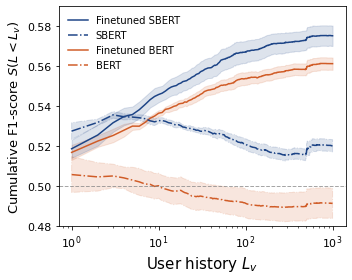

In [25]:
colors = ['#D05C27', '#1D4486', '#D05C27', '#1D4486']
lstyle = ['-','-','-.','-.']
fig, ax = plt.subplots(figsize=(5,4))

for idx, model_type in enumerate(model_types):
    plt.plot(np.arange(1,1001), model2mat_f1[model_type].mean(axis=0), label='%s'%(model_labels[idx]), color=colors[idx], lw=1.5, ls=lstyle[idx])
    yerr = model2mat_f1[model_type].std(axis=0)/np.sqrt(5)
    plt.fill_between(np.arange(1,1001), y1 = model2mat_f1[model_type].mean(axis=0)+yerr,y2 = model2mat_f1[model_type].mean(axis=0)-yerr, color=colors[idx], alpha=0.15, ls=lstyle[idx])
    #plt.errorbar(np.arange(1,1001), model2mat_f1[model_type].mean(axis=0),yerr=yerr, color=colors[idx], alpha=0.3, lw=2, ls=lstyle[idx], label='%s'%(model_labels[idx]))

ax.tick_params(axis='both', labelsize=11)

#baseline
plt.xlabel(r'User history $L_v$', fontsize=15)
plt.ylabel('Cumulative F1-score $S(L<L_v)$', fontsize=13)
plt.xscale('log')

custom_order = [1, 3, 0, 2]  
handles, labels = plt.gca().get_legend_handles_labels()
reordered_handles = [handles[idx] for idx in custom_order]
reordered_labels = [labels[idx] for idx in custom_order]
plt.legend(reordered_handles, reordered_labels, frameon=False, fontsize=10, loc=2)

    
#baseline
plt.axhline(0.5, ls='--', lw=1, color='gray', alpha=0.7, label='Random selection')
plt.ylim(0.48,0.59)  
  
plt.tight_layout()

In [26]:
model2mat_acc = {}

for model_type in model_types: 
        
    L = 1000
    mat_acc  = np.zeros((5,L))
    
    for data_idx in range(0,5):
        print(model_type, data_idx)
        df_sample = pd.read_pickle("../dataset/DownstreamTask_Dataframe/downstream_results_data(%d)_model(%s).p"%(data_idx, model_type))
        
        for i in range(L):
            df_ = df_sample[df_sample['votelen']<=i+1]
            mat_acc[data_idx, i] = get_accuracy(df_['true_outcome'], df_['predicted_outcome'])
    
    
    model2mat_acc[model_type] = mat_acc

model_bert_ft 0
model_bert_ft 1
model_bert_ft 2
model_bert_ft 3
model_bert_ft 4
model_roberta-base_ft 0
model_roberta-base_ft 1
model_roberta-base_ft 2
model_roberta-base_ft 3
model_roberta-base_ft 4
model_bert 0
model_bert 1
model_bert 2
model_bert 3
model_bert 4
model_roberta-base 0
model_roberta-base 1
model_roberta-base 2
model_roberta-base 3
model_roberta-base 4


In [ ]:
"""for model_type in model_types:
    with open('../dataset/Downstream_result_vs_length/length2acc_mat_%s'%(model_type), 'wb') as f:
        pickle.dump(model2mat_acc[model_type], f)
        
        
model2mat_acc = {}
for model_type in model_types:
    with open('../dataset/Downstream_result_vs_length/length2acc_mat_%s'%(model_type), 'rb') as f:
        model2mat_acc[model_type] = pickle.load(f)        
"""

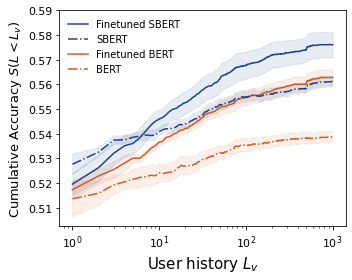

In [27]:
colors = ['#D05C27', '#1D4486', '#D05C27', '#1D4486']
lstyle = ['-','-','-.','-.']
fig, ax = plt.subplots(figsize=(5,4))

for idx, model_type in enumerate(model_types):
    plt.plot(np.arange(1,1001), model2mat_acc[model_type].mean(axis=0), label='%s'%(model_labels[idx]), color=colors[idx], lw=1.5, ls=lstyle[idx])
    yerr = model2mat_acc[model_type].std(axis=0)/np.sqrt(5)
    plt.fill_between(np.arange(1,1001), y1 = model2mat_acc[model_type].mean(axis=0)+yerr,y2 = model2mat_acc[model_type].mean(axis=0)-yerr, color=colors[idx], alpha=0.1, ls=lstyle[idx])

ax.tick_params(axis='both', labelsize=11)

#baseline
plt.xlabel(r'User history $L_v$', fontsize=15)
plt.ylabel('Cumulative Accuracy $S(L<L_v)$', fontsize=13)
plt.xscale('log')

custom_order = [1, 3, 0, 2]  
handles, labels = plt.gca().get_legend_handles_labels()
reordered_handles = [handles[idx] for idx in custom_order]
reordered_labels = [labels[idx] for idx in custom_order]
plt.legend(reordered_handles, reordered_labels, frameon=False, fontsize=10, loc=2)

    
#baseline
#plt.axhline(0.5, ls='--', lw=1.5, color='gray', alpha=0.7, label='Random selection')
plt.ylim(top=0.59)    
  
plt.tight_layout()

In [28]:
model2mat = {}

for model_type in model_types: 
        
    L = 11
    mat  = np.zeros((5,L))
    
    for data_idx in range(0,5):
        #print(model_type, data_idx)
        df_sample = pd.read_pickle("../dataset/DownstreamTask_Dataframe/downstream_results_data(%d)_model(%s).p"%(data_idx, model_type))
        ex = 2
        for i in range(L):
            df_ = df_sample[(ex**i<=df_sample['votelen']) & (df_sample['votelen']<ex**(i+1))]
            mat[data_idx, i] = get_f1_score(df_['true_outcome'], df_['predicted_outcome'])
            print(ex**i,'-' ,ex**(i+1), len(df_))
            
    model2mat[model_type] = mat

    print(model_type)
    print(mat)

1 - 2 2877
2 - 4 3594
4 - 8 3930
8 - 16 4514
16 - 32 4439
32 - 64 4725
64 - 128 3933
128 - 256 3037
256 - 512 1756
512 - 1024 610
1024 - 2048 676
1 - 2 3168
2 - 4 3777
4 - 8 4198
8 - 16 4975
16 - 32 4742
32 - 64 5004
64 - 128 4235
128 - 256 2894
256 - 512 1797
512 - 1024 665
1024 - 2048 671
1 - 2 2774
2 - 4 3475
4 - 8 4070
8 - 16 4796
16 - 32 4952
32 - 64 5491
64 - 128 4699
128 - 256 3687
256 - 512 1596
512 - 1024 1398
1024 - 2048 497
1 - 2 3037
2 - 4 3440
4 - 8 3391
8 - 16 3802
16 - 32 3569
32 - 64 3515
64 - 128 3087
128 - 256 2170
256 - 512 1082
512 - 1024 588
1024 - 2048 685
1 - 2 2626
2 - 4 3195
4 - 8 3854
8 - 16 4366
16 - 32 4490
32 - 64 4912
64 - 128 4355
128 - 256 3204
256 - 512 1768
512 - 1024 902
1024 - 2048 385
model_bert_ft
[[0.52439845 0.54266051 0.53839179 0.56035371 0.58056818 0.57712745
  0.55857493 0.5783447  0.65651677 0.54095435 0.57062116]
 [0.50327993 0.52924649 0.55192641 0.56608341 0.57514212 0.58449636
  0.59630291 0.59623863 0.60655805 0.66766917 0.56785777]
 [0

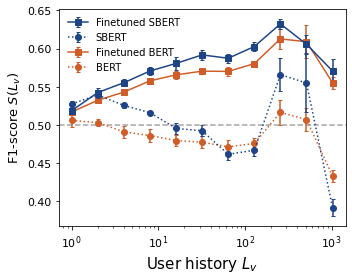

In [29]:
colors = ['#D05C27', '#1D4486', '#D05C27', '#1D4486']
lstyle = ['s-','s-','o:','o:']
fig, ax = plt.subplots(figsize=(5,4))

for idx, model_type in enumerate(model_types):
    x = [ex**l for l in range(L)]
    y = pd.DataFrame(model2mat[model_type]).mean()

    #plt.plot(x, y, color=colors[idx], lw=1.5, ls=lstyle[idx],  label='%s'%(model_labels[idx]))
    yerr = model2mat[model_type].std(axis=0)/np.sqrt(5)
    #plt.fill_between(x, y1 = y+yerr, y2=y-yerr, color=colors[idx], alpha=0.1, ls=lstyle[idx])
    plt.errorbar(x, y, yerr = yerr, color=colors[idx], fmt=lstyle[idx], capsize=2, label='%s'%(model_labels[idx]))

ax.tick_params(axis='both', labelsize=11)

#baseline
plt.xlabel(r'User history $L_v$', fontsize=15)
plt.ylabel('F1-score $S(L_v)$', fontsize=13)
plt.xscale('log')

custom_order = [1, 3, 0, 2]  
handles, labels = plt.gca().get_legend_handles_labels()
reordered_handles = [handles[idx] for idx in custom_order]
reordered_labels = [labels[idx] for idx in custom_order]
plt.legend(reordered_handles, reordered_labels, frameon=False, fontsize=10, loc=2)

    
#baseline
#plt.ylim(top=0.59)    
plt.axhline(0.5, ls='--', lw=1.5, color='gray', alpha=0.7, label='Random selection')
  
plt.tight_layout()

## Length distribution

In [30]:
def logbinning(data, numbin=30):
    # log-scaled bins
    bins = np.logspace(0, np.log2(max(data)), num=numbin, base=2)
    widths = (bins[1:] - bins[:-1])

    # Calculate histogram
    hist = np.histogram(data, bins=bins)
    # normalize by bin width
    hist_norm = hist[0]/widths

    # plot it!
    x = bins[:-1]
    y = hist_norm
    
    return x, y, widths

In [31]:
Ls = []
for data_idx in range(5):
    
    result = pd.read_pickle("../dataset/DownstreamTask_Dataframe/downstream_results_data(%d)_model(%s).p"%(data_idx, model_types[0])) 
    
    df_g = result.groupby('username')
      
    votelengths = []
    for g, df_ in df_g:
        votelengths.append(df_['votelen'].iloc[0])
        
    Ls.append(votelengths)

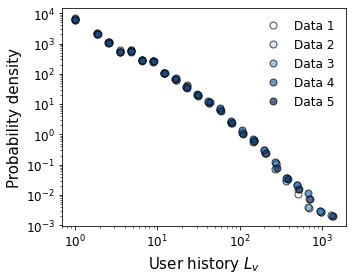

In [32]:
#colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854']

viridis_map = plt.cm.get_cmap('Blues')
color_values = np.linspace(0, 1, 5)
cmap = [viridis_map(color_val) for color_val in color_values]

plt.figure(figsize=(5,4))

for i in range(len(Ls)):
    x, y, widths = logbinning(Ls[i], numbin=25)
    plt.loglog(x, y, 'o', ms=7, alpha=0.7, markeredgecolor='k', c=cmap[i],  label='Data %d'%(i+1))

plt.xlabel(r'User history $L_v$', fontsize=15)
plt.ylabel('Probability density', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(frameon=False, fontsize=12)
plt.tight_layout()
#plt.savefig('../fig/vote_length_distribution(5fold_data).pdf', transparent=True)
plt.show()

## Visualization - belief space

In [33]:
model_types = ['model_bert_ft', 'model_roberta-base_ft', 'model_bert', 'model_roberta-base']
model_labels = ['BERT (Fine-tuned)', 'S-BERT (Fine-tuned)', 'BERT', 'S-BERT'] 
data_idx = 0

In [35]:
#load dictionary {beliefs: embedding vector}  

model2beleifemb = {}
for model_type in model_types:
    with open('../dataset/BeliefEmbeddingResults/BeliefEmbeddings_data(0)_model(%s).p'%(model_type), 'rb') as f:
        model2beleifemb[model_type] = pickle.load(f)


### load belief vectors

In [36]:
belief_keys = list(model2beleifemb['model_roberta-base_ft'].keys())
belief_vectors = list(model2beleifemb['model_roberta-base_ft'].values())

idx2belief = {}
belief2idx = {}

for i in range(len(belief_keys)):
    idx2belief[i] = belief_keys[i]
    belief2idx[belief_keys[i]] = i

## PCA of belief vectors

In [37]:
from sklearn.manifold import TSNE                   # final reduction
from sklearn.decomposition import PCA                   # final reduction

pca = PCA(random_state=42)
pca.fit(belief_vectors)
pca_vectors = pca.transform(belief_vectors)
pca_x_vals = np.array([v[0] for v in pca_vectors])
pca_y_vals = np.array([v[1] for v in pca_vectors])

dat_pc = pd.DataFrame({'x':pca_x_vals, 'y':pca_y_vals})

### Entire belief space

<Figure size 720x576 with 0 Axes>

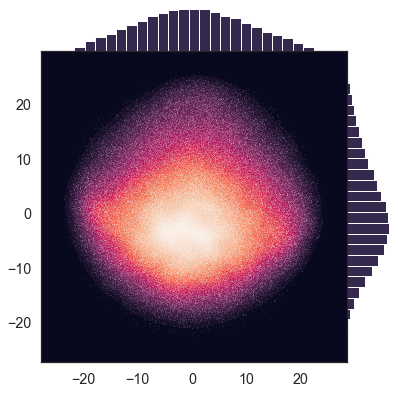

In [38]:
rc = {'figure.figsize':(10,8)}
sns.set_theme(style="white", font_scale=1.3, rc=rc)


plt.figure()
g = sns.JointGrid(data=dat_pc, x="x", y="y", space=0.0, ratio=7)

g.ax_joint.set_facecolor("black")

g.plot_joint(sns.kdeplot,
             fill=True, 
             thresh=0,
             cmap="rocket",
             levels=100)

sns.scatterplot(x=pca_x_vals, y=pca_y_vals, fc="w", s=0.1,  ax=g.ax_joint)

g.plot_marginals(sns.histplot, color="#35294E", alpha=1, bins=25)

g.set_axis_labels(xlabel=None, )

#plt.savefig('../fig/BeliefSpaceExamples/belief_space_visualization_smooth.png', transparent=True, bbox_inches='tight')
plt.show()

### Beliefs including specific keywords

In [39]:
def get_related_beliefs(keywords, pc_x=0, pc_y=1): 
    #pc_x, pc_y = pc index
    related_beliefs = set()
    related_beliefs_vectors = []
    related_beliefs_pcvec = []

    for e in belief_keys:
        for k in keywords:
            if k.lower() in e.lower(): #convert to lower case 
                related_beliefs.add(e)
    
    related_beliefs = list(related_beliefs)
    for b in related_beliefs:
        b_idx = belief2idx[b]
        related_beliefs_vectors.append(belief_vectors[b_idx])
        related_beliefs_pcvec.append(pca_vectors[b_idx])

    related_beliefs_vectors = np.array(related_beliefs_vectors)            
    related_beliefs_pcvec   = np.array(related_beliefs_pcvec)

    x = related_beliefs_pcvec[:,pc_x]
    y = related_beliefs_pcvec[:,pc_y]
    
    dat = pd.DataFrame({'x':x, 'y':y, 'belief':related_beliefs})
    
    print("N samples:", len(x))
    return x, y, dat

In [40]:
def draw_keyword_kde(keywords, pc_x=0, pc_y=1, palette='rocket', labeloff=0):
    
    color = palette
            
    x, y, dat = get_related_beliefs(keywords, pc_x, pc_y)
    sns.set_theme(style="white", font_scale=1.3)
    g = sns.JointGrid(data=dat, x="x", y="y", space=0.0, ratio=7)
    
    
    sns.kdeplot(data=dat, x='x', y='y', fill=True, thresh=0, cmap=color, levels=100, ax=g.ax_joint)
    g.ax_joint.set_facecolor("black")
    g.plot_marginals(sns.histplot, color="#35294E", alpha=1, bins=25)
    g.set_axis_labels(xlabel=None)
    
    ax=g.ax_joint
    ax.set_xticks([-20, 0, 20])
    
    if labeloff==0:
        if len(keywords) > 2:
            ax.text(.02, .97,  s=", ".join(keywords), ha='left', va='top', color='w', fontsize=22, transform=ax.transAxes)
        else:
            ax.text(.02, .97,  s=", ".join(keywords), ha='left', va='top', color='w', fontsize=23, transform=ax.transAxes)
        
    return g

N samples: 5324


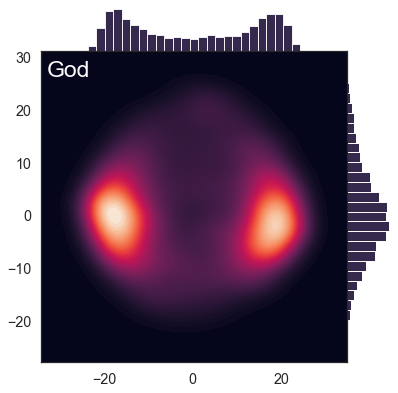

In [41]:
keywords = ['God']
draw_keyword_kde(keywords, labeloff=0)
#plt.savefig('../fig/BeliefSpaceExamples/belief_kdeplot_keyword_(%s)'%(keywords[0]), transparent=0, bbox_inches='tight')

## PC1-PC2

N samples: 908
N samples: 3860
N samples: 1302
N samples: 1392
N samples: 464
N samples: 380
N samples: 242
N samples: 710


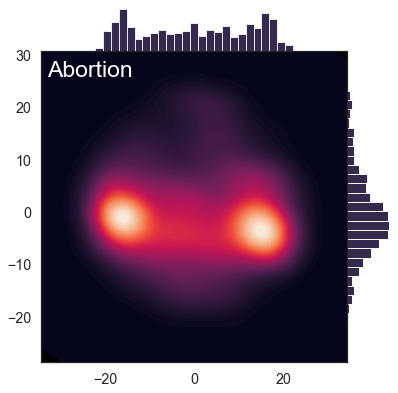

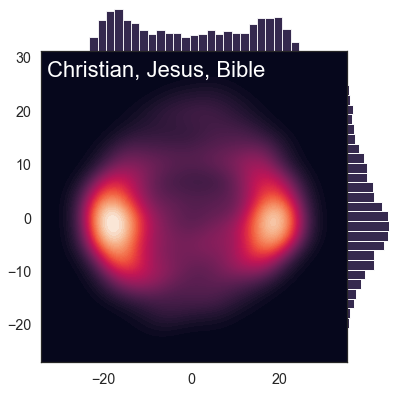

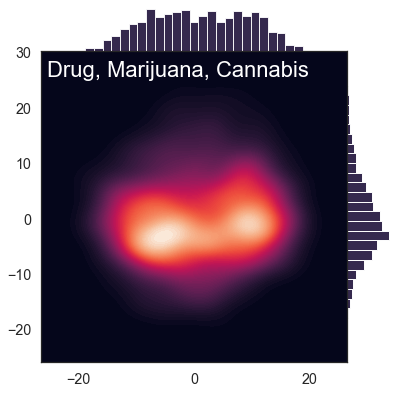

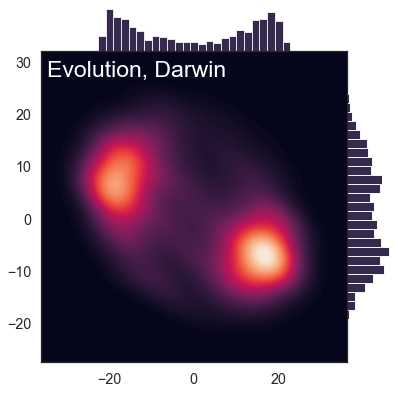

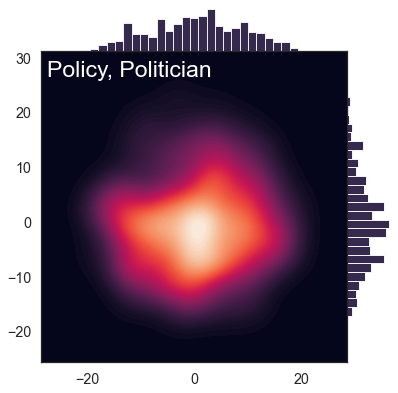

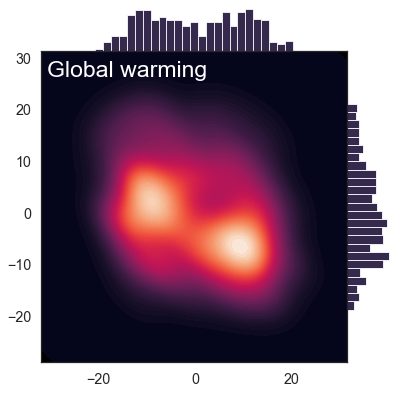

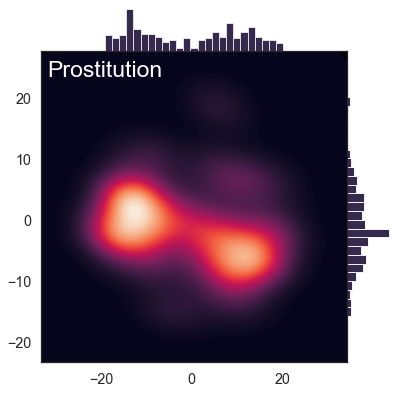

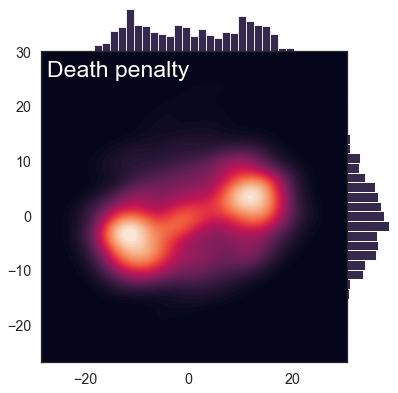

In [42]:
#Data
keywords = ['Abortion']
draw_keyword_kde(keywords)
#plt.savefig('../fig/BeliefSpaceExamples/belief_kdeplot_keyword_(%s)'%(keywords[0]), transparent=False, bbox_inches='tight')

keywords = ['Christian', 'Jesus', 'Bible']
draw_keyword_kde(keywords)
#plt.savefig('../fig/BeliefSpaceExamples/belief_kdeplot_keyword_(%s)'%(keywords[0]), transparent=False, bbox_inches='tight')

keywords = ['Drug', 'Marijuana', 'Cannabis']
draw_keyword_kde(keywords)
#plt.savefig('../fig/BeliefSpaceExamples/belief_kdeplot_keyword_(%s)'%(keywords[0]), transparent=False, bbox_inches='tight')

keywords = ['Evolution','Darwin']
draw_keyword_kde(keywords)
#plt.savefig('../fig/BeliefSpaceExamples/belief_kdeplot_keyword_(%s)'%(keywords[0]), transparent=False, bbox_inches='tight')

keywords = ['Policy', 'Politician']
draw_keyword_kde(keywords)
#plt.savefig('../fig/BeliefSpaceExamples/belief_kdeplot_keyword_(%s)'%(keywords[0]), transparent=False, bbox_inches='tight')

keywords = ['Global warming']
draw_keyword_kde(keywords)
#plt.savefig('../fig/BeliefSpaceExamples/belief_kdeplot_keyword_(%s)'%(keywords[0]), transparent=False, bbox_inches='tight')

keywords = ['Prostitution']
draw_keyword_kde(keywords)
#plt.savefig('../fig/BeliefSpaceExamples/belief_kdeplot_keyword_(%s)'%(keywords[0]), transparent=False, bbox_inches='tight')

keywords = ['Death penalty']
draw_keyword_kde(keywords)
#plt.savefig('../fig/BeliefSpaceExamples/belief_kdeplot_keyword_(%s)'%(keywords[0]), transparent=False, bbox_inches='tight')

### PC2 - PC3

N samples: 342
N samples: 138


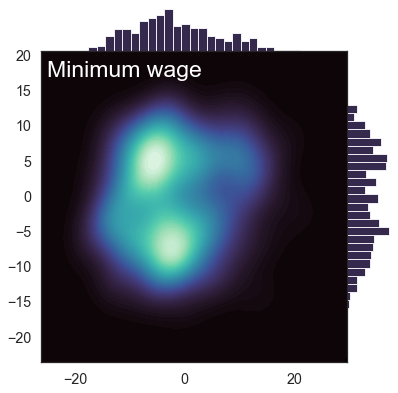

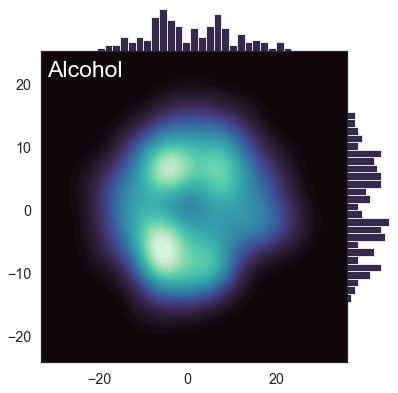

In [44]:
keywords = ['Minimum wage']
draw_keyword_kde(keywords, 1, 2, palette='mako')
#plt.savefig('../fig/BeliefSpaceExamples/belief_kdeplot_keyword_(%s)'%(keywords[0]), transparent=False, bbox_inches='tight')

keywords = ['Alcohol']
draw_keyword_kde(keywords, 1, 2, palette='mako')
#plt.savefig('../fig/BeliefSpaceExamples/belief_kdeplot_keyword_(%s)'%(keywords[0]), transparent=False, bbox_inches='tight')

### Higher dimension

N samples: 324
N samples: 158
N samples: 140


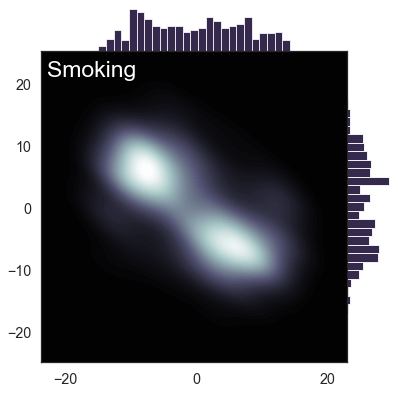

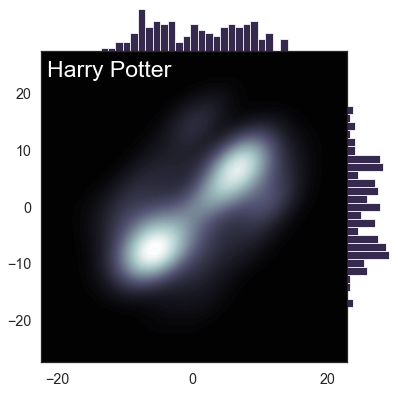

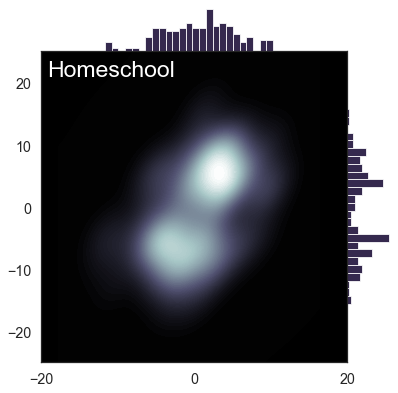

In [46]:
keywords = ['Smoking']
draw_keyword_kde(keywords, 3, 4, palette='bone')
#plt.savefig('../fig/BeliefSpaceExamples/belief_kdeplot_keyword_(%s)'%(keywords[0]), transparent=False, bbox_inches='tight')

keywords = ['Harry Potter']
draw_keyword_kde(keywords, 2, 3, palette='bone')
#plt.savefig('../fig/BeliefSpaceExamples/belief_kdeplot_keyword_(%s)'%(keywords[0]), transparent=False, bbox_inches='tight')

keywords = ['Homeschool']
draw_keyword_kde(keywords, 2, 3, palette='bone')
#plt.savefig('../fig/BeliefSpaceExamples/belief_kdeplot_keyword_(%s)'%(keywords[0]), transparent=False, bbox_inches='tight')

## + UMAP of belief vectors

In [56]:
import umap

In [57]:
reducer = umap.UMAP(n_neighbors=20, n_components=2, random_state=42, spread=3 )
data_2d = reducer.fit_transform(belief_vectors)

/Users/byunghwee/miniforge3/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [58]:
dat_umap = pd.DataFrame({'x':data_2d[:,0], 'y':data_2d[:,1]})
dat_umap.head()

x         y
0  1.916479 -0.008987
1 -0.305726  6.860794
2  6.805717 -1.217850
3  9.789492  6.680282
4  1.443168 -4.058787

<AxesSubplot:xlabel='x', ylabel='y'>

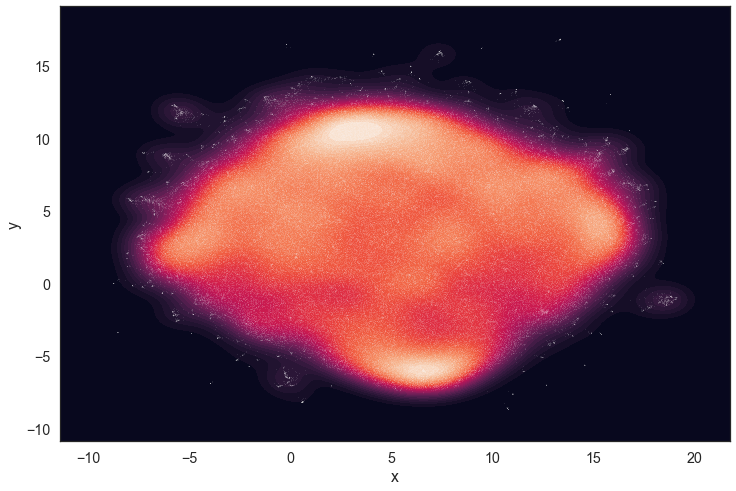

In [59]:
fig,ax = plt.subplots(figsize=(12,8))
sns.kdeplot(x=dat_umap['x'], y=dat_umap['y'], cmap='rocket', fill=True, thresh=0, levels=100, ax=ax)
sns.scatterplot(x=dat_umap['x'], y=dat_umap['y'], fc="w", s=0.1,  ax=ax)


<Figure size 864x576 with 0 Axes>

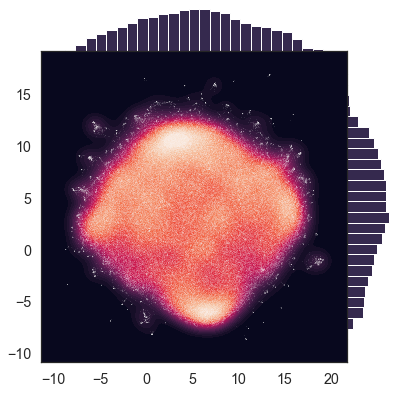

In [60]:
rc = {'figure.figsize':(12,8)}
sns.set_theme(style="white", font_scale=1.3, rc=rc)


plt.figure()
g = sns.JointGrid(data=dat_umap, x="x", y="y", space=0.0, ratio=7)

g.ax_joint.set_facecolor("black")

g.plot_joint(sns.kdeplot,
             fill=True, 
             thresh=0,
             cmap="rocket",
             levels=100)

sns.scatterplot(x=dat_umap['x'], y=dat_umap['y'], fc="w", s=0.1,  ax=g.ax_joint)

g.plot_marginals(sns.histplot, color="#35294E", alpha=1, bins=25)

g.set_axis_labels(xlabel=None, )

#plt.savefig('../fig/BeliefSpaceExamples(UMAP)/belief_space_visualization_smooth.png', transparent=True, bbox_inches='tight')
plt.show()

In [61]:
def get_related_beliefs_umap(keywords): 
    related_beliefs = set()
    related_beliefs_umapvec = []

    for e in belief_keys:
        for k in keywords:
            if k.lower() in e.lower(): #convert to lower case 
                related_beliefs.add(e)
    
    related_beliefs = list(related_beliefs)
    
    for b in related_beliefs:
        b_idx = belief2idx[b]
        related_beliefs_umapvec.append(data_2d[b_idx])

    related_beliefs_umapvec = np.array(related_beliefs_umapvec)

    x = related_beliefs_umapvec[:,0]
    y = related_beliefs_umapvec[:,1]
    
    dat = pd.DataFrame({'x':x, 'y':y, 'belief':related_beliefs})
    
    print("N samples:", len(x))
    return x, y, dat

In [62]:
def draw_keyword_kde_umap(keywords, palette='rocket', labeloff=0):
    
    color = palette
            
    x, y, dat = get_related_beliefs_umap(keywords)    
    sns.set_theme(style="white", font_scale=1.3)
    g = sns.JointGrid(data=dat, x="x", y="y", space=0.0, ratio=7)
    
    ax = g.ax_joint
    #ax.fill_betweenx([30, 30], -30, 30, color='black')
    sns.kdeplot(data=dat, x='x', y='y', fill=True, thresh=0.0, cmap=color, levels=100, ax=ax)
    ax.set_facecolor("black")
    g.plot_marginals(sns.histplot, color="#DF6E50", alpha=1, linewidth=0.5, edgecolor='k', bins=25)
    g.set_axis_labels(xlabel=None)
        
    
    for line in plt.gca().get_lines():
        line.set_color('k')
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    

    
    if labeloff==0:
        if len(keywords) > 2:
            ax.text(.02, .97,  s=", ".join(keywords), ha='left', va='top', color='w', fontsize=22, transform=ax.transAxes)
        else:
            ax.text(.02, .97,  s=", ".join(keywords), ha='left', va='top', color='w', fontsize=23, transform=ax.transAxes)
    
    return g

In [63]:
def draw_scatter_umap(keywords, ax, color='r', alpha=1):
    
    x, y, dat = get_related_beliefs_umap(keywords)
    sns.scatterplot(x=dat['x'], y=dat['y'], marker='o', color=color, s=5,  alpha=alpha, linewidth=0.0,
                    ax=ax, label='%s'%", ".join(keywords))
    #ax.set_axis_off()

N samples: 5324
N samples: 908
N samples: 1618
N samples: 242
N samples: 380
N samples: 1392
N samples: 710
N samples: 324
N samples: 342
N samples: 158


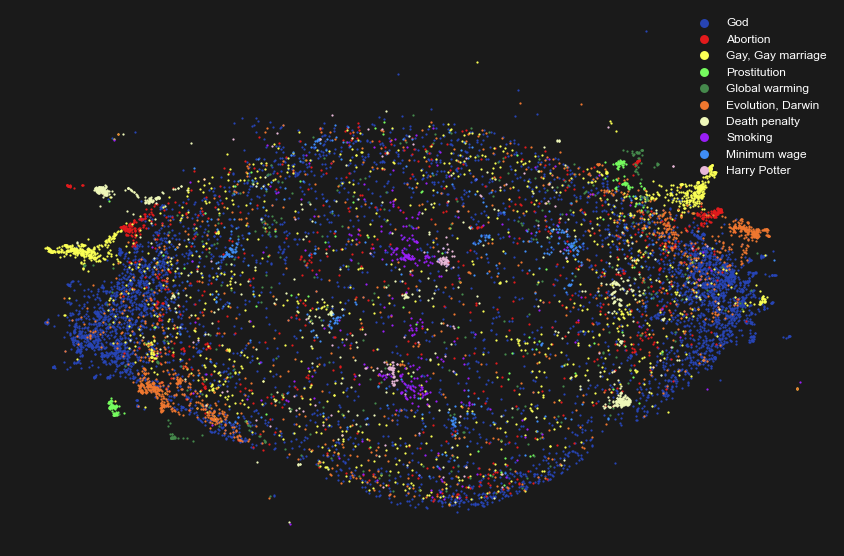

In [73]:
keywords_list = [['Abortion'], 
                 ['Gay','Gay marriage'], 
                 ['Prostitution'], 
                 ['Global warming'], 
                 ['Evolution','Darwin'], 
                 ['Death penalty'],
                 ['Smoking'], 
                 ['Minimum wage'],
                 ['Harry Potter']]

colors = [
"#e31a1c", 
"#FAFF54",
"#75FB5E",
"#45894C",
"#EE772F",
"#EFF8B9",
"#991EF6",
"#3F8DF7",
"#E8B8D8",
]

sns.set_theme(style="white", font_scale=1.3)

fig, ax = plt.subplots(facecolor='k', figsize=(12,8))
draw_scatter_umap(['God'], ax, color='#2744B4', alpha=1)#323690

for idx, keyword in enumerate(keywords_list):
    #print(keyword)
    color = plt.cm.gist_rainbow(idx / len(keywords_list))
    draw_scatter_umap(keyword, ax, color=colors[idx])
    
    
ax.set_facecolor('k')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("")
ax.set_ylabel("")

for pos in ['right', 'top', 'bottom', 'left']: 
    ax.spines[pos].set_visible(False)

ax.legend(markerscale=4, loc=1, fontsize=12, frameon=False, labelcolor='w')
plt.tight_layout()
#plt.savefig('../fig/BeliefSpaceExamples(UMAP)/keywords_umap.png', dpi=300)
plt.show()


N samples: 5324
N samples: 908
N samples: 1618
N samples: 242
N samples: 380
N samples: 1392
N samples: 710
N samples: 342
N samples: 138
N samples: 158
N samples: 140
N samples: 324


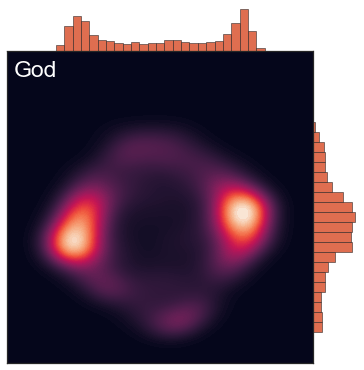

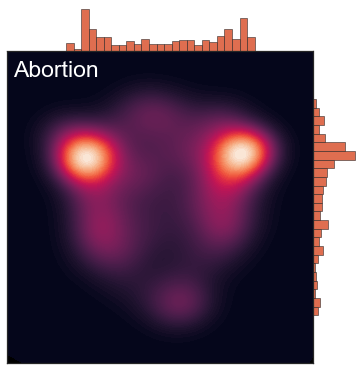

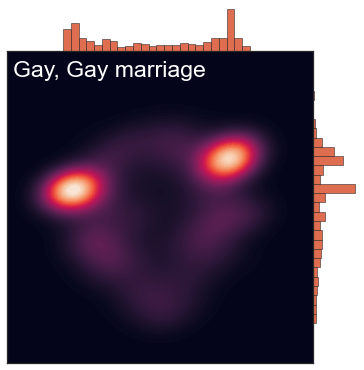

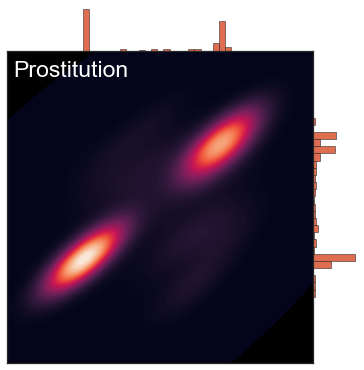

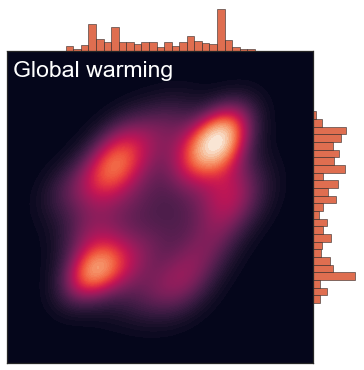

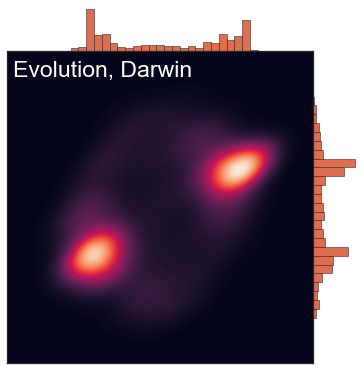

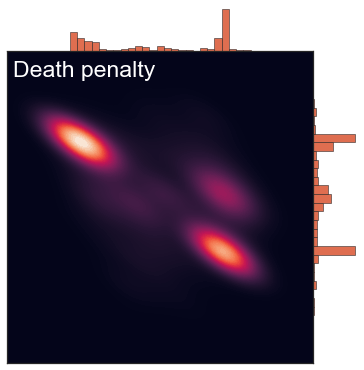

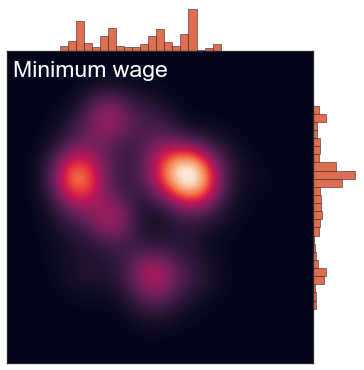

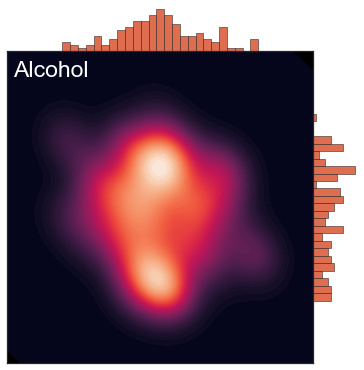

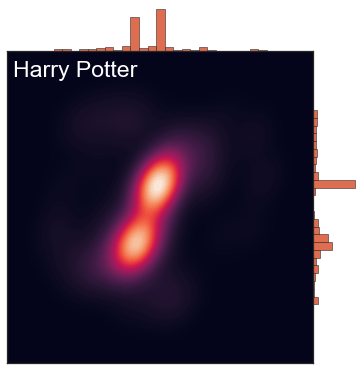

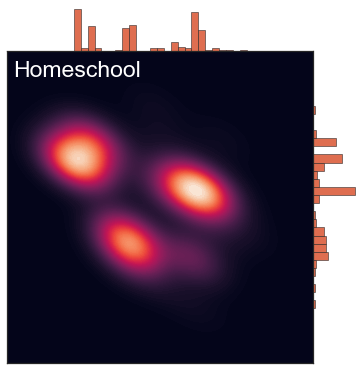

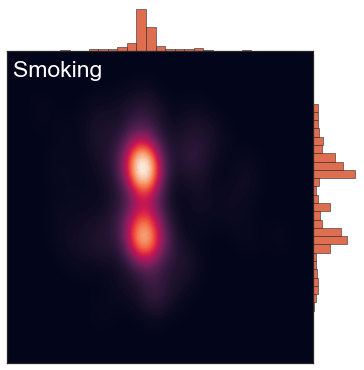

In [65]:
keywords_list = [['God'], ['Abortion'], ['Gay','Gay marriage'], ['Prostitution'], 
                 ['Global warming'], ['Evolution','Darwin'], ['Death penalty'], 
                 ['Minimum wage'], ['Alcohol'], ['Harry Potter'], ['Homeschool'], ['Smoking']]

for idx, keyword in enumerate(keywords_list):

    draw_keyword_kde_umap(keyword)
    
    #plt.savefig('../fig/BeliefSpaceExamples(UMAP)/belief_kdeplot_keyword_(%s).png'%(keyword[0]), 
    #        dpi=300, transparent=0, bbox_inches='tight')
    

## User embeddings

In [75]:
model_types = ['model_bert_ft', 'model_roberta-base_ft', 'model_bert', 'model_roberta-base']#, 'model_sbert_ft', 'model_sbert'
model_labels = ['BERT (Fine-tuned)', 'S-BERT (Fine-tuned)', 'BERT', 'S-BERT'] #, 'Finetuned SBERT roberta', 'SBERT roberta'

data_idx = 0

In [77]:
with open('../dataset/UserEmbeddings/user2embeddingvector_data(%d)_model(model_roberta-base_ft).p'%data_idx, 'rb') as f:
    user2embedding_ft = pickle.load(f)
    
with open('../dataset/UserEmbeddings/user2embeddingvector_data(%d)_model(model_roberta-base).p'%data_idx, 'rb') as f:
    user2embedding_base = pickle.load(f)    

In [78]:
len(user2embedding_ft), len(user2embedding_base)

(35447, 35447)

In [80]:
import zipfile
import os
import json

In [81]:
zip_file_path = '../dataset/userdata/users.json.zip'
extract_path = os.path.dirname(zip_file_path)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

with open('../dataset/userdata/users.json','r') as f:
    userinfo = json.load(f)

### Finding PC space of original belief space

In [82]:
#load dictionary {beliefs: embedding vector}  
model2beleifemb = {}
for model_type in model_types:
    with open('../dataset/BeliefEmbeddingResults/BeliefEmbeddings_data(0)_model(%s).p'%(model_type), 'rb') as f:
        model2beleifemb[model_type] = pickle.load(f)

In [83]:
belief_keys_ft = list(model2beleifemb['model_roberta-base_ft'].keys())
belief_vectors_ft = list(model2beleifemb['model_roberta-base_ft'].values())        

belief_keys_base = list(model2beleifemb['model_roberta-base'].keys())
belief_vectors_base = list(model2beleifemb['model_roberta-base'].values())        

In [84]:
from sklearn.manifold import TSNE                   # final reduction
from sklearn.decomposition import PCA                   # final reduction

pca_ft = PCA(random_state=42)
pca_ft.fit(belief_vectors_ft)

pca_base = PCA(random_state=42)
pca_base.fit(belief_vectors_base)


PCA(random_state=42)

In [85]:
## Representing users in the same PC space

In [86]:
#2dim np.array two rows of usermat_ft and usermat_base represent the same user
usermat_ft = []
for user in user2embedding_ft:
    usermat_ft.append(user2embedding_ft[user])
usermat_ft = np.array(usermat_ft)

usermat_base = []
for user in user2embedding_base:
    usermat_base.append(user2embedding_base[user])
usermat_base = np.array(usermat_base)

(usermat_ft.shape, usermat_base.shape)

((35447, 768), (35447, 768))

In [87]:
#pca transform (get user representation in PC space)
user_pc_ft = pca_ft.transform(usermat_ft)
user_pc_base = pca_base.transform(usermat_base)

### User information 

### A. Political party

In [90]:
parties = np.zeros( len(user2embedding_ft) )

party_type = {'Democratic Party':1, 'Republican Party':2}

for idx, e in enumerate(user2embedding_ft):
    if e in userinfo and userinfo[e]['party'] in party_type:
        parties[idx] = party_type[userinfo[e]['party']]
            
parties = parties.astype(int)                

democratic_indices = []
republican_indices = []

for idx, e in enumerate(parties):
    if e == 1:
        democratic_indices.append(idx)
    elif e ==2:
        republican_indices.append(idx)
        
print(len(democratic_indices), len(republican_indices), len(democratic_indices)+len(republican_indices))
print("out of", len(user2embedding_ft))

1652 1683 3335
out of 35447


## B. Christian vs. Atheist

In [92]:
religion_info = np.zeros( len(user2embedding_ft) )

for idx, e in enumerate(user2embedding_ft):
    if e in userinfo:
        if 'Christian' in userinfo[e]['religious_ideology']:
            religion_info[idx] = 1
        elif  userinfo[e]['religious_ideology'] == 'Atheist':
            religion_info[idx] = 2
    
religion_info = religion_info.astype(int)                

In [93]:
christian_indices = []
atheist_indices = []

for idx, e in enumerate(religion_info):
    if e == 1:
        christian_indices.append(idx)
    elif e ==2:
        atheist_indices.append(idx)

print(len(christian_indices), len(atheist_indices), len(christian_indices)+len(atheist_indices))
print("out of", len(user2embedding_ft))

4906 2788 7694
out of 35447


In [94]:
category2groups = {} #category -> {group별 index list} dictionary 형태로 저장

category2groups['Political party'] = {'Republican': republican_indices, 'Democratic': democratic_indices}
category2groups['Religion'] = {'Christian': christian_indices, 'Atheist': atheist_indices}

category2groups['Religion'].keys()

dict_keys(['Christian', 'Atheist'])

### C. Other issues

In [96]:
big_issues = list(userinfo['000001']['big_issues_dict'].keys())
len(big_issues)

48

In [97]:
for issue in tqdm(big_issues):
    
    pro_indices = []
    con_indices = []

    for idx, e in enumerate(user2embedding_ft):

        if e in userinfo:

            if userinfo[e]['big_issues_dict'][issue] == 'Pro':
                pro_indices.append(idx)            

            elif userinfo[e]['big_issues_dict'][issue] == 'Con':
                con_indices.append(idx)
    
    category2groups[issue] = {'Pro':pro_indices, 'Con':con_indices} 

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 29.80it/s]


In [98]:
for issue in category2groups.keys():
    print(issue)
    for e in category2groups[issue]:
        print(e, len(category2groups[issue][e]))
    print()

Political party
Republican 1683
Democratic 1652

Religion
Christian 4906
Atheist 2788

Abortion
Pro 5138
Con 5046

Affirmative Action
Pro 1970
Con 3648

Animal Rights
Pro 4807
Con 1033

Barack Obama
Pro 2225
Con 2962

Border Fence
Pro 3713
Con 3459

Capitalism
Pro 3562
Con 1331

Civil Unions
Pro 4255
Con 1640

Death Penalty
Pro 4889
Con 4749

Drug Legalization
Pro 4683
Con 4388

Electoral College
Pro 1555
Con 2399

Environmental Protection
Pro 7037
Con 1007

Estate Tax
Pro 1782
Con 3042

European Union
Pro 1792
Con 1189

Euthanasia
Pro 3776
Con 1748

Federal Reserve
Pro 1117
Con 1289

Flat Tax
Pro 2093
Con 2637

Free Trade
Pro 3030
Con 682

Gay Marriage
Pro 6509
Con 2725

Global Warming Exists
Pro 6043
Con 2120

Globalization
Pro 2180
Con 1015

Gold Standard
Pro 1321
Con 1134

Gun Rights
Pro 5840
Con 2533

Homeschooling
Pro 3062
Con 1384

Internet Censorship
Pro 725
Con 4612

Iran-Iraq War
Pro 1174
Con 5183

Labor Union
Pro 3514
Con 1690

Legalized Prostitution
Pro 2599
Con 2209

Medic

In [99]:
idx2user = {}
user2idx = {}

for idx, e in enumerate(user2embedding_ft):
    idx2user[idx] = e
    user2idx[e] = idx

In [100]:
with open('../dataset/User_survey/idx2user.p','wb') as f:
    pickle.dump(idx2user, f)

with open('../dataset/User_survey/user2idx.p','wb') as f:
    pickle.dump(user2idx, f)
    
with open('../dataset/User_survey/issue2groups(useridx).p','wb') as f:
    pickle.dump(category2groups, f)    

## Visualization - SBERT-Finetuned

In [101]:
with open('../dataset/04_K-fold_dataset/df_train_idx%d.p'%data_idx, 'rb') as f:
    df_train = pickle.load(f)
    
user2history = {}
for g, dat in df_train.groupby('username'):
    user2history[g] = len(dat)    

In [102]:
history_length = []
for e in user2embedding_ft:
    history_length.append(user2history[e])
history_length = np.array(history_length)    

### kde plot (political party)

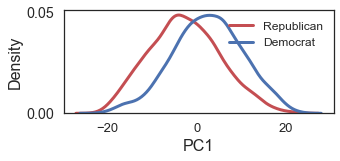

In [103]:
all_indices = category2groups['Political party']['Republican'] + category2groups['Political party']['Democratic']

xs = []
ys = []
sizes = []
colors = []
parties = []

node_size = 12*np.log(history_length)

np.random.shuffle(all_indices)

for e in all_indices:
    xs.append( user_pc_ft[e,0] )
    ys.append( user_pc_ft[e,1] )
    sizes.append( node_size[e] )
    
    if e in category2groups['Political party']['Democratic']:
        colors.append('b')
        parties.append('Democratic') 
    else:
        colors.append('r')
        parties.append('Republican') 
        

dat = pd.DataFrame({'x':xs, 'y':ys, 'size':sizes, 'party':parties})

plt.figure(figsize=(5,2.5))
plt.xticks([-20, 0, 20], fontsize=13)
plt.yticks([0, 0.05])

g = sns.kdeplot(data=dat[dat['party']=='Republican'], x='x', lw=3, color='r', label='Republican') 
g = sns.kdeplot(data=dat[dat['party']=='Democratic'], x='x', lw=3, color='b', label='Democrat') 

plt.legend(frameon=False, fontsize=12)



plt.xlabel('PC1', fontsize=16)
plt.ylabel('Density', fontsize=16)

plt.tight_layout()
#plt.savefig('../fig/UserEmbeddingPC/political_party_histogram(roberta-base-ft).pdf',transparent=True, bbox_inches='tight')

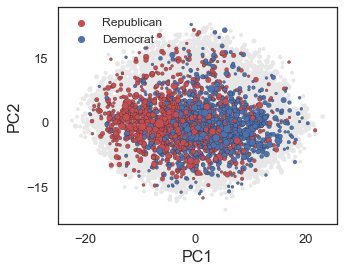

In [104]:
plt.figure(figsize=(5,4))
ax = plt.axes()

plt.scatter(user_pc_ft[:,0], user_pc_ft[:,1], marker='o', s=node_size, color='#E7E7E7')
plt.scatter(xs, ys, s=sizes, marker='o', alpha=1, color=colors, edgecolor='k', lw=0.2)

plt.scatter([],[], color='#E7E7E7')
plt.scatter([],[], color='r', label='Republican')
plt.scatter([],[], color='b', label='Democrat')

plt.xticks([-20, 0, 20],fontsize=13)
plt.yticks([-15, 0, +15],fontsize=13)

plt.xlabel('PC1', fontsize=16)
plt.ylabel('PC2', fontsize=16)
plt.legend(loc=2, fontsize=12, frameon=False)
#plt.savefig('../fig/UserEmbeddingPC/political_party_scatter(roberta-base-ft).pdf',transparent=True, bbox_inches='tight')
#plt.savefig('../fig/UserEmbeddingPC/political_party_scatter(roberta-base-ft).png', dpi=300, transparent=0, bbox_inches='tight')
plt.show()


### kde plot (Religion)

In [106]:
category2groups['Religion'].keys()

dict_keys(['Christian', 'Atheist'])

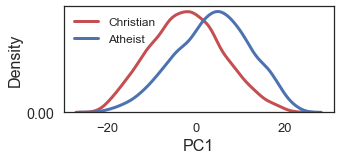

In [107]:
all_indices = category2groups['Religion']['Christian'] + category2groups['Religion']['Atheist']

xs = []
ys = []
sizes = []
colors = []
parties = []

node_size = 12*np.log(history_length)

np.random.shuffle(all_indices)

for e in all_indices:
    xs.append( user_pc_ft[e,0] )
    ys.append( user_pc_ft[e,1] )
    sizes.append( node_size[e] )
    
    if e in category2groups['Religion']['Christian']:
        colors.append('r')
        parties.append('Christian') 
    else:
        colors.append('b')
        parties.append('Atheist') 
        

dat = pd.DataFrame({'x':xs, 'y':ys, 'size':sizes, 'Religion':parties})

plt.figure(figsize=(5,2.5))
plt.xticks([-20, 0, 20], fontsize=13)
plt.yticks([0, 0.05])

g = sns.kdeplot(data=dat[dat['Religion']=='Christian'], x='x', lw=3, color='r', label='Christian') 
g = sns.kdeplot(data=dat[dat['Religion']=='Atheist'], x='x', lw=3, color='b', label='Atheist') 

plt.legend(frameon=False, fontsize=12)



plt.xlabel('PC1', fontsize=16)
plt.ylabel('Density', fontsize=16)

plt.tight_layout()
#plt.savefig('../fig/UserEmbeddingPC/religion_histogram(roberta-base-ft).pdf',transparent=True, bbox_inches='tight')

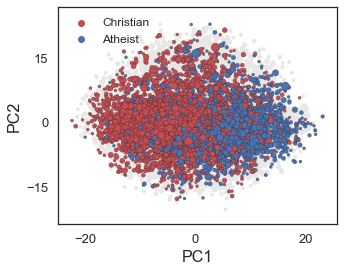

In [108]:
plt.figure(figsize=(5,4))
ax = plt.axes()

plt.scatter(user_pc_ft[:,0], user_pc_ft[:,1], marker='o', s=node_size, color='#E7E7E7')
plt.scatter(xs, ys, s=sizes, marker='o', alpha=1, color=colors, edgecolor='k', lw=0.2)

plt.scatter([],[], color='#E7E7E7')
plt.scatter([],[], color='r', label='Christian')
plt.scatter([],[], color='b', label='Atheist')

plt.xticks([-20, 0, 20],fontsize=13)
plt.yticks([-15, 0, +15],fontsize=13)

plt.xlabel('PC1', fontsize=16)
plt.ylabel('PC2', fontsize=16)
plt.legend(loc=2, fontsize=12, frameon=False)
#plt.savefig('../fig/UserEmbeddingPC/religion_scatter(roberta-base-ft).pdf',transparent=True, bbox_inches='tight')
#plt.savefig('../fig/UserEmbeddingPC/religion_scatter(roberta-base-ft).png',transparent=0, dpi=300, bbox_inches='tight')
plt.show()


## Visualization - Base-SBERT model

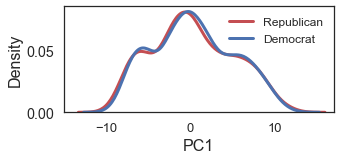

In [109]:
all_indices = category2groups['Political party']['Republican'] + category2groups['Political party']['Democratic']

xs = []
ys = []
sizes = []
colors = []
parties = []

node_size = 12*np.log(history_length)

np.random.shuffle(all_indices)

for e in all_indices:
    xs.append( user_pc_base[e,0] )
    ys.append( user_pc_base[e,1] )
    sizes.append( node_size[e] )
    
    if e in category2groups['Political party']['Democratic']:
        colors.append('b')
        parties.append('Democratic') 
    else:
        colors.append('r')
        parties.append('Republican') 
        

dat = pd.DataFrame({'x':xs, 'y':ys, 'size':sizes, 'party':parties})

plt.figure(figsize=(5,2.5))
plt.xticks(fontsize=13)
plt.yticks([0, 0.05])
plt.xlim(-15,17)
g = sns.kdeplot(data=dat[dat['party']=='Republican'], x='x', lw=3, color='r', label='Republican') 
g = sns.kdeplot(data=dat[dat['party']=='Democratic'], x='x', lw=3, color='b', label='Democrat') 

plt.legend(frameon=False, fontsize=12)



plt.xlabel('PC1', fontsize=16)
plt.ylabel('Density', fontsize=16)

plt.tight_layout()
#plt.savefig('../fig/UserEmbeddingPC/political_party_histogram(base).pdf',transparent=True, bbox_inches='tight')

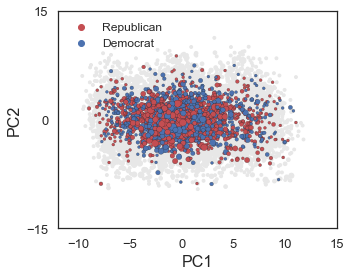

In [110]:
plt.figure(figsize=(5,4))
ax = plt.axes()

plt.scatter(user_pc_base[:,0], user_pc_base[:,1], marker='o', s=node_size, color='#E7E7E7')
plt.scatter(xs, ys, s=sizes, marker='o', alpha=1, color=colors, edgecolor='k', lw=0.2)

plt.scatter([],[], color='#E7E7E7')
plt.scatter([],[], color='r', label='Republican')
plt.scatter([],[], color='b', label='Democrat')

plt.xticks(fontsize=13)
plt.yticks([-15, 0, +15],fontsize=13)
plt.xlim(-12,15)
plt.xlabel('PC1', fontsize=16)
plt.ylabel('PC2', fontsize=16)
plt.legend(loc=2, fontsize=12, frameon=False)
#plt.savefig('../fig/UserEmbeddingPC/political_party_scatter(base).pdf',transparent=True, bbox_inches='tight')
#plt.savefig('../fig/UserEmbeddingPC/political_party_scatter(base).png',transparent=0,dpi=300, bbox_inches='tight')
plt.show()


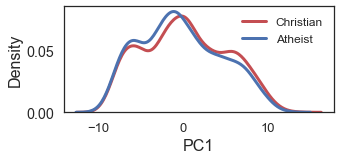

In [111]:
all_indices = category2groups['Religion']['Christian'] + category2groups['Religion']['Atheist']

xs = []
ys = []
sizes = []
colors = []
parties = []

node_size = 12*np.log(history_length)

np.random.shuffle(all_indices)

for e in all_indices:
    xs.append( user_pc_base[e,0] )
    ys.append( user_pc_base[e,1] )
    sizes.append( node_size[e] )
    
    if e in category2groups['Religion']['Christian']:
        colors.append('r')
        parties.append('Christian') 
    else:
        colors.append('b')
        parties.append('Atheist') 
        

dat = pd.DataFrame({'x':xs, 'y':ys, 'size':sizes, 'Religion':parties})

plt.figure(figsize=(5,2.5))
plt.xticks(fontsize=13)
plt.yticks([0, 0.05])

g = sns.kdeplot(data=dat[dat['Religion']=='Christian'], x='x', lw=3, color='r', label='Christian') 
g = sns.kdeplot(data=dat[dat['Religion']=='Atheist'], x='x', lw=3, color='b', label='Atheist') 

plt.legend(frameon=False, fontsize=12)



plt.xlabel('PC1', fontsize=16)
plt.ylabel('Density', fontsize=16)

plt.tight_layout()
#plt.savefig('../fig/UserEmbeddingPC/religion_histogram(base).pdf',transparent=True, bbox_inches='tight')

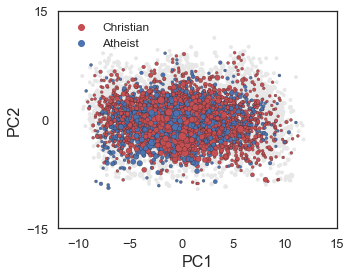

In [112]:
plt.figure(figsize=(5,4))
ax = plt.axes()

plt.scatter(user_pc_base[:,0], user_pc_base[:,1], marker='o', s=node_size, color='#E7E7E7')
plt.scatter(xs, ys, s=sizes, marker='o', alpha=1, color=colors, edgecolor='k', lw=0.2)

plt.scatter([],[], color='#E7E7E7')
plt.scatter([],[], color='r', label='Christian')
plt.scatter([],[], color='b', label='Atheist')

plt.xticks(fontsize=13)
plt.yticks([-15, 0, +15],fontsize=13)

plt.xlabel('PC1', fontsize=16)
plt.ylabel('PC2', fontsize=16)
plt.xlim(-12,15)
plt.legend(loc=2, fontsize=12, frameon=False)
#plt.savefig('../fig/UserEmbeddingPC/religion_scatter(base).pdf',transparent=True, bbox_inches='tight')
#plt.savefig('../fig/UserEmbeddingPC/religion_scatter(base).png',transparent=0, dpi=300, bbox_inches='tight')
plt.show()


## Big issue visualization 

In [113]:
category2groups.keys()

dict_keys(['Political party', 'Religion', 'Abortion', 'Affirmative Action', 'Animal Rights', 'Barack Obama', 'Border Fence', 'Capitalism', 'Civil Unions', 'Death Penalty', 'Drug Legalization', 'Electoral College', 'Environmental Protection', 'Estate Tax', 'European Union', 'Euthanasia', 'Federal Reserve', 'Flat Tax', 'Free Trade', 'Gay Marriage', 'Global Warming Exists', 'Globalization', 'Gold Standard', 'Gun Rights', 'Homeschooling', 'Internet Censorship', 'Iran-Iraq War', 'Labor Union', 'Legalized Prostitution', 'Medicaid & Medicare', 'Medical Marijuana', 'Military Intervention', 'Minimum Wage', 'National Health Care', 'National Retail Sales Tax', 'Occupy Movement', 'Progressive Tax', 'Racial Profiling', 'Redistribution', 'Smoking Ban', 'Social Programs', 'Social Security', 'Socialism', 'Stimulus Spending', 'Term Limits', 'Torture', 'United Nations', 'War in Afghanistan', 'War on Terror', 'Welfare'])

In [114]:
def visualize_issue(issue, ax,  color1='orange', color2='#4D6EAC', finetuned=True): 
    
    all_indices = category2groups[issue]['Pro'] + category2groups[issue]['Con']
    xs = []
    ys = []
    sizes = []
    colors = []
    parties = []

    node_size = 12*np.log(history_length)

    np.random.shuffle(all_indices)

    if finetuned:
        user_pc = user_pc_ft
    else:
        user_pc = user_pc_base
    
    for e in all_indices:

        xs.append( user_pc[e,0] )
        ys.append( user_pc[e,1] )            
        sizes.append( node_size[e] )

        if e in category2groups[issue]['Pro']:
            colors.append(color2)
            parties.append('Pro') 
        else:
            colors.append(color1)
            parties.append('Con') 


    dat = pd.DataFrame({'x':xs, 'y':ys, 'size':sizes, 'party':parties})

    ax.scatter(user_pc[:,0], user_pc[:,1], marker='o', s=node_size, color='#E7E7E7')
    ax.scatter(xs, ys, s=sizes, marker='o', alpha=1, color=colors, edgecolor='k', lw=0.15)

    ax.scatter([],[], color='#E7E7E7')
    ax.scatter([],[], color=color2, label='Pro')
    ax.scatter([],[], color=color1, label='Con')

    ax.set_xlabel('PC1', fontsize=16)
    ax.set_ylabel('PC2', fontsize=16)
    ax.legend(loc=2, fontsize=12, frameon=False)

In [115]:
len(category2groups['Gay Marriage']['Pro']), len(category2groups['Gay Marriage']['Con']), 

(6509, 2725)

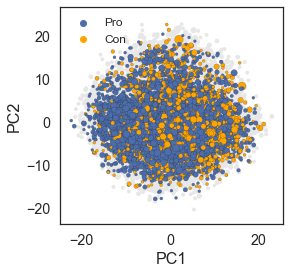

In [116]:
fig, ax = plt.subplots(figsize=(4,4))
visualize_issue('Gun Rights', ax=ax )

In [117]:
top_issues = [
"Gay Marriage",
"Abortion",
"Euthanasia",
"Global Warming Exists",
"National Health Care",
"Legalized Prostitution",
"Progressive Tax",
"Drug Legalization",
"Socialism",
"Border Fence",
"Smoking Ban",
"Affirmative Action"]

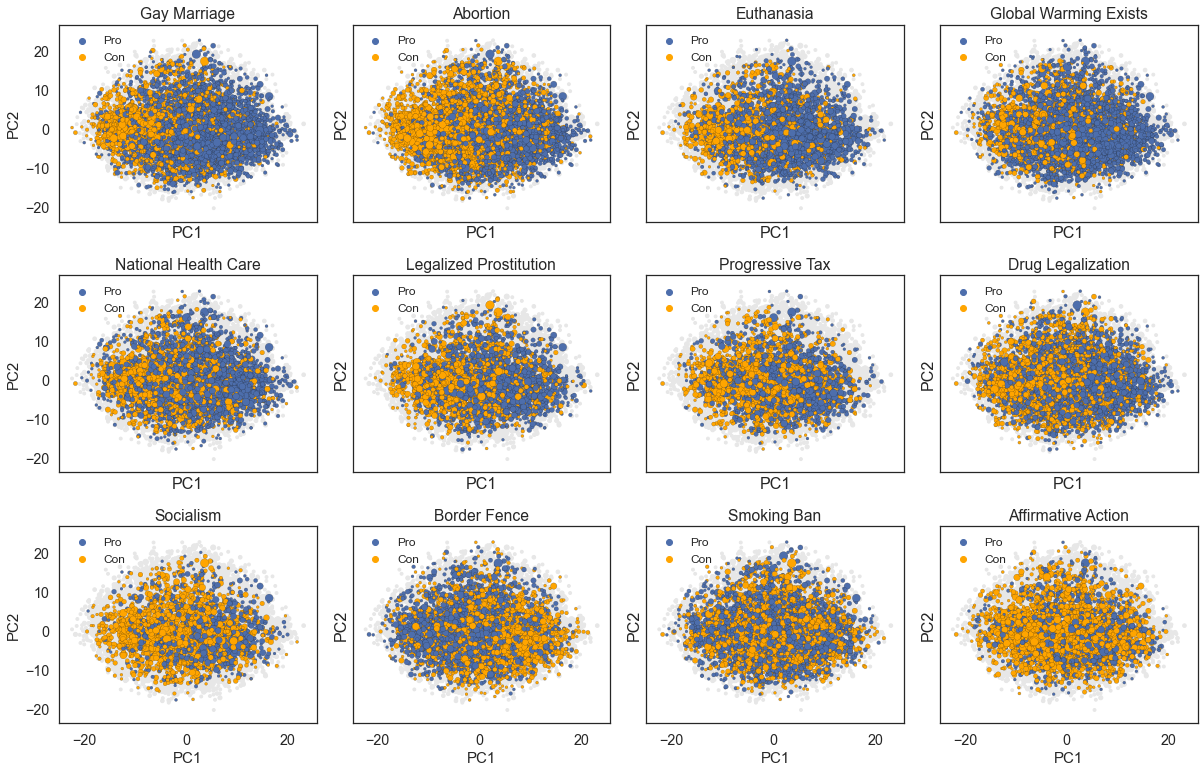

In [118]:
fig = plt.figure(figsize=(17,11))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

for idx, issue in enumerate(top_issues):
    ax = fig.add_subplot(3, 4, idx+1)
    visualize_issue(issue, ax)
    ax.set_title(issue)
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    if idx//4==2:
        ax.set_xticks([-20,0,20])
        ax.set_xlabel('PC1', fontsize=15)
    if idx%4==0:
        ax.set_yticks([-20,-10,0,10,20])
        ax.set_ylabel('PC2', fontsize=15)

        
plt.tight_layout()
#plt.savefig('../fig/UserEmbeddingPC/BigIssues_PCA_SBERT-ft.pdf', transparent=True, bbox_inches='tight')    
#plt.savefig('../fig/UserEmbeddingPC/BigIssues_PCA_SBERT-ft.png', dpi=200, transparent=0, bbox_inches='tight')    
plt.show()

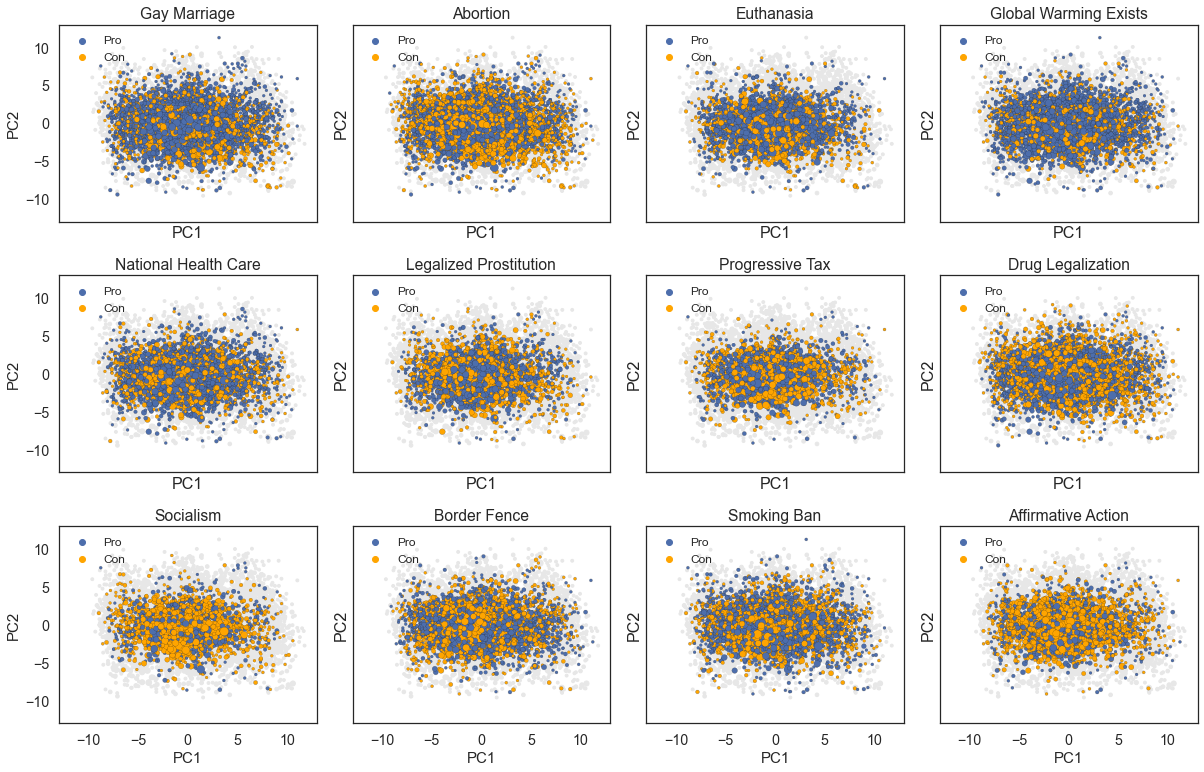

In [119]:
fig = plt.figure(figsize=(17,11))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

for idx, issue in enumerate(top_issues):
    ax = fig.add_subplot(3, 4, idx+1)
    visualize_issue(issue, ax, finetuned=False)
    ax.set_title(issue)
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.set_xlim(-13,13)
    ax.set_ylim(-13,13)
    
    if idx//4==2:
        ax.set_xticks([-10,-5,0,5,10])        
        ax.set_xlabel('PC1', fontsize=15)
    if idx%4==0:
        ax.set_yticks([-10,-5,0,5,10]) 
        ax.set_ylabel('PC2', fontsize=15)

        
plt.tight_layout()
#plt.savefig('../fig/UserEmbeddingPC/BigIssues_PCA_SBERT-base.pdf', transparent=True, bbox_inches='tight')    
#plt.savefig('../fig/UserEmbeddingPC/BigIssues_PCA_SBERT-base.png', dpi=200, transparent=0, bbox_inches='tight')    
plt.show()

## Issue vector

In [120]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

In [121]:
with open('../dataset/User_survey/issue2groups(useridx).p', 'rb') as f:
    category2groups = pickle.load(f)
    
with open('../dataset/User_survey/idx2user.p', 'rb') as f:
    idx2user = pickle.load(f)    
    
with open('../dataset/UserEmbeddings/user2embeddingvector_data(0)_model(model_roberta-base_ft).p', 'rb') as f:
    user2embedding_ft = pickle.load(f)        

In [122]:
usermat_ft = []
usernames = []

for user in user2embedding_ft:
    usermat_ft.append(user2embedding_ft[user])
    usernames.append(user)
    
usermat_ft = np.array(usermat_ft)

### Calculating issue vectors

In [124]:
issue2vector = {}

for issue in list(category2groups.keys()): 
    
    if issue=='Religion' or issue=='Political party':
        continue 
        
    print(issue)

    g1, g2 = category2groups[issue].keys()

    g1_indices = category2groups[issue][g1]
    g2_indices = category2groups[issue][g2]
    print(g1, usermat_ft[g1_indices].shape)
    print(g2, usermat_ft[g2_indices].shape)

    group2avgvector = {}
    group2avgvector[g1] = usermat_ft[g1_indices].mean(axis=0)
    group2avgvector[g2] = usermat_ft[g2_indices].mean(axis=0)

    issue2vector[issue] = group2avgvector[g1] - group2avgvector[g2]

Abortion
Pro (5138, 768)
Con (5046, 768)
Affirmative Action
Pro (1970, 768)
Con (3648, 768)
Animal Rights
Pro (4807, 768)
Con (1033, 768)
Barack Obama
Pro (2225, 768)
Con (2962, 768)
Border Fence
Pro (3713, 768)
Con (3459, 768)
Capitalism
Pro (3562, 768)
Con (1331, 768)
Civil Unions
Pro (4255, 768)
Con (1640, 768)
Death Penalty
Pro (4889, 768)
Con (4749, 768)
Drug Legalization
Pro (4683, 768)
Con (4388, 768)
Electoral College
Pro (1555, 768)
Con (2399, 768)
Environmental Protection
Pro (7037, 768)
Con (1007, 768)
Estate Tax
Pro (1782, 768)
Con (3042, 768)
European Union
Pro (1792, 768)
Con (1189, 768)
Euthanasia
Pro (3776, 768)
Con (1748, 768)
Federal Reserve
Pro (1117, 768)
Con (1289, 768)
Flat Tax
Pro (2093, 768)
Con (2637, 768)
Free Trade
Pro (3030, 768)
Con (682, 768)
Gay Marriage
Pro (6509, 768)
Con (2725, 768)
Global Warming Exists
Pro (6043, 768)
Con (2120, 768)
Globalization
Pro (2180, 768)
Con (1015, 768)
Gold Standard
Pro (1321, 768)
Con (1134, 768)
Gun Rights
Pro (5840, 768)

In [125]:
issue_mat = []
for issue in issue2vector:
    issue_mat.append(issue2vector[issue])
    
issue_mat = np.array(issue_mat)    
issue_mat.shape

(48, 768)

In [126]:
issue_vec_norms = np.linalg.norm(issue_mat, axis=1)
issue_titles = [issue for issue in issue2vector]

df_iv = pd.DataFrame({'Issue':issue_titles, 'Norm':issue_vec_norms})    
df_iv = df_iv.sort_values(by='Norm', ascending=0)

In [127]:
df_iv.to_pickle('../dataset/User_survey/df_issuevector.pkl')

Text(0, 0.5, '')

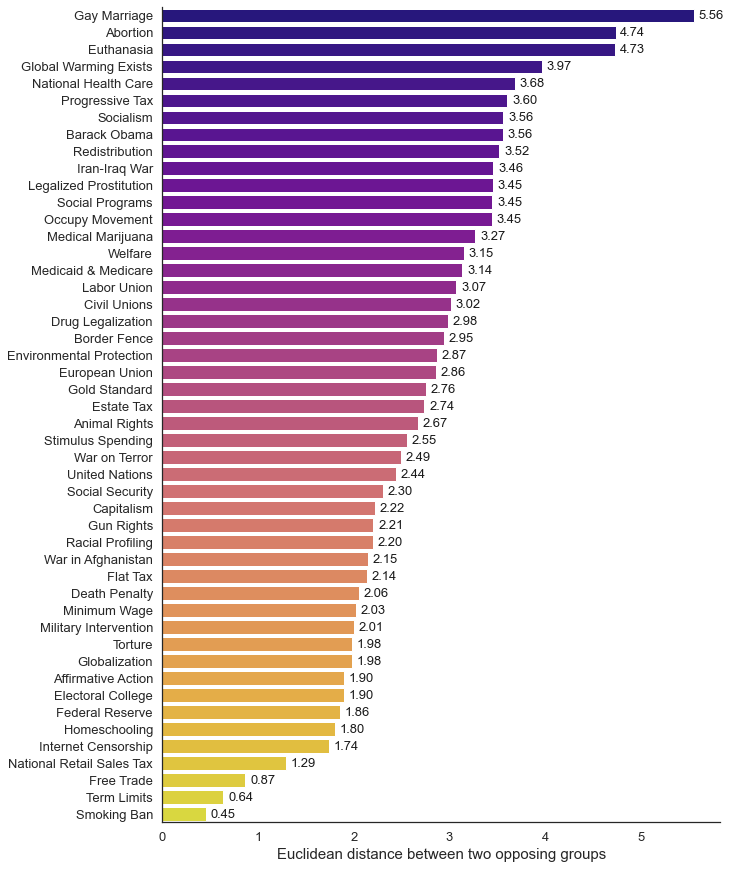

In [128]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(10, 15))

sns.barplot(x="Norm", y="Issue", data=df_iv, palette='plasma')

for idx, p in enumerate(ax.patches):
    width = p.get_width()
    plt.text(p.get_width()+0.05, p.get_y()+0.55*p.get_height(),
             '{:1.2f}'.format(width),ha='left', va='center', size=13, color='k')

plt.ylabel('Social Issue', fontsize=15)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Euclidean distance between two opposing groups', fontsize=15)
ax.set_ylabel("")

#plt.savefig('../fig/Issue_vector/48issue_vector_distance.pdf', transparent=True, bbox_inches='tight')

## Comparison with survey result 

In [129]:
stance_mat = np.empty((len(usernames), 48+1))#big issues + political party
stance_mat[:] = np.nan 

for user_idx, e in enumerate(usernames): 
    if not e in userinfo: continue
    
    for idx, issue in enumerate(userinfo[e]['big_issues_dict']):
        if userinfo[e]['big_issues_dict'][issue] == 'Pro':
            stance_mat[user_idx, idx] = 1 
        elif userinfo[e]['big_issues_dict'][issue] == 'Con':
            stance_mat[user_idx, idx] = 0 

    if userinfo[e]['party'] == 'Republican Party':
        stance_mat[user_idx, 48] = 1
    elif userinfo[e]['party']== 'Democratic Party':
        stance_mat[user_idx, 48] = 0
    
    """if 'Christian' in userinfo[e]['religious_ideology']:
        stance_mat[user_idx, 49] = 1
    elif userinfo[e]['religious_ideology'] == 'Atheist':
        stance_mat[user_idx, 49] = 0"""

In [130]:
stance_mat.shape

(35447, 49)

In [131]:
column = list(userinfo[e]['big_issues_dict'].keys()) + ['Political_party'] # ['Religion'] 
df_stance = pd.DataFrame(stance_mat, columns=column)
df_stance = df_stance.dropna(subset=['Political_party'])

print(df_stance.shape)
df_stance.head()

(3335, 49)


Abortion  Affirmative Action  Animal Rights  Barack Obama  Border Fence  \
8         0.0                 NaN            1.0           1.0           1.0   
32        0.0                 NaN            NaN           0.0           NaN   
57        1.0                 1.0            NaN           1.0           1.0   
79        NaN                 NaN            NaN           NaN           NaN   
104       NaN                 NaN            NaN           NaN           NaN   

     Capitalism  Civil Unions  Death Penalty  Drug Legalization  \
8           NaN           1.0            0.0                0.0   
32          1.0           NaN            1.0                0.0   
57          1.0           1.0            1.0                1.0   
79          NaN           NaN            NaN                NaN   
104         NaN           NaN            NaN                NaN   

     Electoral College  ...  Social Security  Socialism  Stimulus Spending  \
8                  1.0  ...              1.0        NaN                NaN   
32                 0.0  ...              NaN        0.0                NaN   
57                 1.0  ...              1.0        NaN                1.0   
79                 NaN  ...              NaN        NaN                NaN   
104                NaN  ...              NaN        NaN                NaN   

     Term Limits  Torture  United Nations  War in Afghanistan  War on Terror  \
8            NaN      0.0             1.0                 NaN            1.0   
32           NaN      0.0             NaN                 1.0            1.0   
57           1.0      1.0             1.0                 1.0            1.0   
79           NaN      NaN             NaN                 NaN            NaN   
104          NaN      NaN             1.0                 NaN            1.0   

     Welfare  Political_party  
8        1.0              0.0  
32       NaN              1.0  
57       1.0              0.0  
79       NaN              1.0  
104      NaN              0.0  

[5 rows x 49 columns]

In [132]:
df_rep = df_stance[df_stance['Political_party']==1]
df_dem = df_stance[df_stance['Political_party']==0]

In [133]:
rep_count = []
dem_count = []

for col in column:
    rep_count.append(len(df_rep[col].dropna()))
    dem_count.append(len(df_dem[col].dropna()))

print('The number of samples for each issue')    
print('rep:', rep_count)
print('dem:', dem_count)


The number of samples for each issue
rep: [1335, 857, 591, 791, 1153, 718, 802, 1301, 1220, 603, 970, 745, 354, 659, 343, 755, 529, 1136, 1054, 376, 320, 1250, 559, 618, 846, 751, 605, 832, 1075, 472, 972, 969, 682, 366, 674, 899, 411, 1048, 736, 877, 620, 342, 943, 611, 932, 949, 1090, 948, 1683]
dem: [1207, 734, 628, 648, 959, 455, 863, 1163, 1069, 482, 1133, 673, 340, 639, 255, 666, 362, 1177, 1116, 330, 265, 985, 412, 534, 952, 790, 450, 970, 1051, 360, 1005, 987, 580, 255, 619, 903, 222, 940, 841, 924, 356, 245, 837, 562, 994, 984, 944, 927, 1652]


In [134]:
#이슈별 찬성 비율
pro_ratio = pd.DataFrame(df_rep.mean(axis=0), columns=['Republican'])
pro_ratio['Democratic'] = df_dem.mean(axis=0)

pro_ratio['N_Rep'] = rep_count
pro_ratio['N_Dem'] = dem_count

pro_ratio = pro_ratio.drop(index='Political_party')

pro_ratio['Difference'] = pro_ratio['Republican'] - pro_ratio['Democratic']
pro_ratio['Absolute_difference'] = np.abs(pro_ratio['Republican'] - pro_ratio['Democratic'])

pro_ratio.index.name = 'Social_issue'

In [135]:
#combine with issue vector distance data
df_iv.columns = ['Social_issue', 'Euclidean_distance']

issue2eucdist = {}
for i in range(len(df_iv)):
    issue2eucdist[df_iv.iloc[i]['Social_issue']] = df_iv.iloc[i]['Euclidean_distance']
    
pro_ratio['Euclidean_distance'] = pro_ratio.index.map(issue2eucdist)    

pro_ratio.to_csv('../dataset/User_survey/ddo_issue_survey_pro_ratio.csv', sep=',')

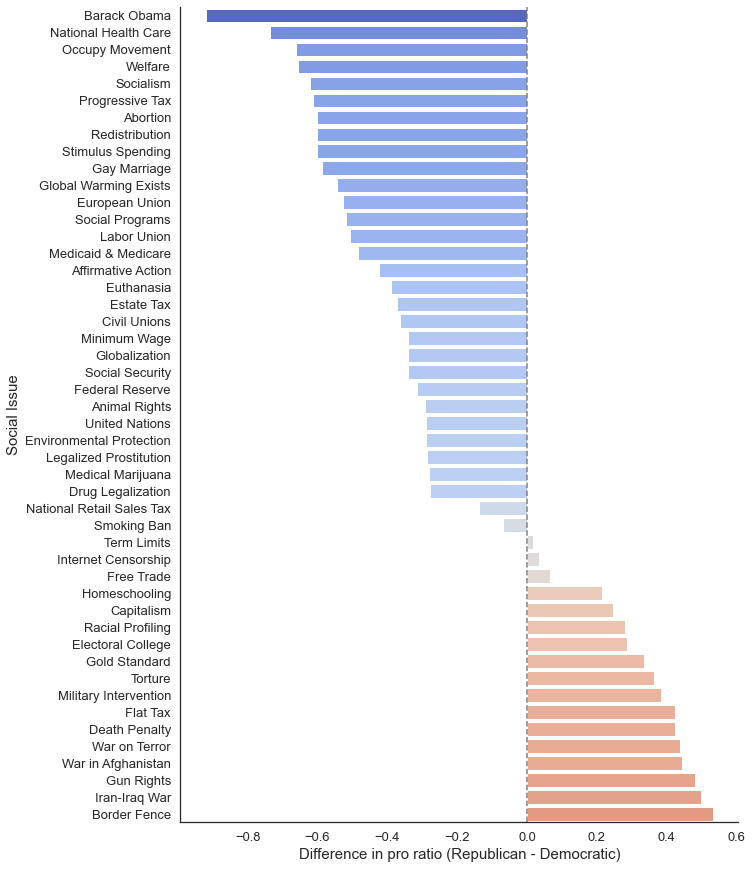

In [136]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(10, 15))
sorted_data = pro_ratio.sort_values(by='Difference')

#color mapping
norm = Normalize(vmin=-1, vmax=1)
sm = ScalarMappable(norm=norm, cmap='coolwarm')
colors = sm.to_rgba(sorted_data['Difference'])

sns.barplot(x='Difference', y=sorted_data.index, data=sorted_data, palette=colors)
#plt.title('Difference in pro ratios between Republican and Democratic parties', fontsize=15)
plt.xlabel('Difference in pro ratio (Republican - Democratic)', fontsize=15)
plt.ylabel('Social Issue', fontsize=15)
plt.yticks(fontsize=13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(fontsize=13)
plt.axvline(x=0, color='grey', linestyle='--')  # Mark the 0 difference
#plt.savefig('../fig/Issue_vector/ddo_issue_pro_ratio_difference.pdf', transparent=True, bbox_inches='tight')
plt.show()

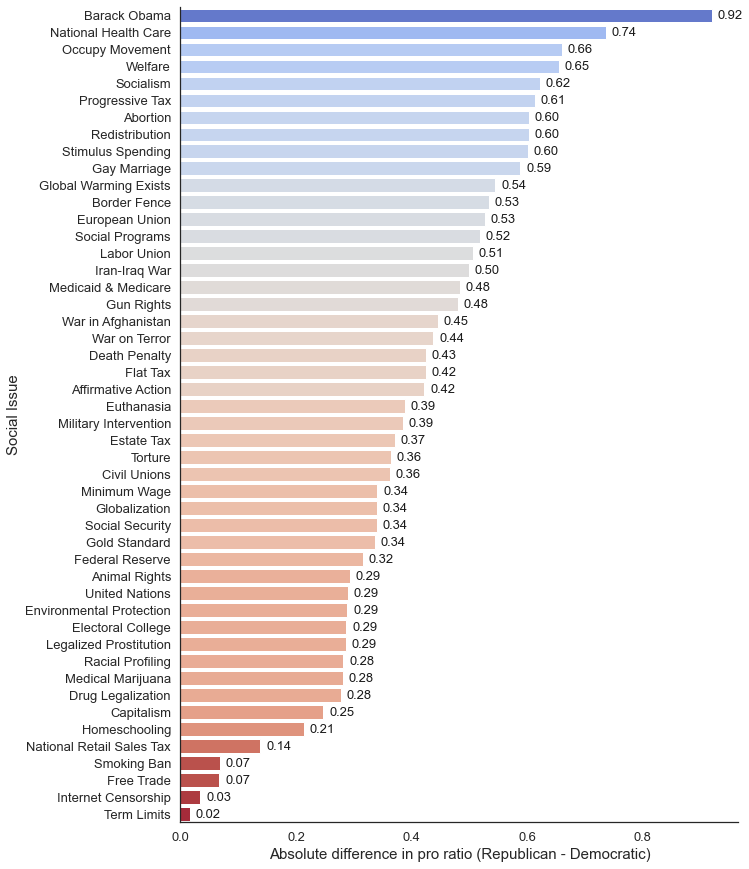

In [137]:
fig, ax = plt.subplots(figsize=(10, 15))
sorted_data = pro_ratio.sort_values(by='Absolute_difference', ascending=False)

#color mapping
norm = Normalize(vmin=0, vmax=1)
sm = ScalarMappable(norm=norm, cmap='coolwarm_r')
colors = sm.to_rgba(sorted_data['Absolute_difference'])

sns.barplot(x='Absolute_difference', y=sorted_data.index, data=sorted_data, palette=colors)


for idx, p in enumerate(ax.patches):
    width = p.get_width()
    plt.text(p.get_width()+0.01, p.get_y()+0.55*p.get_height(),
             '{:1.2f}'.format(width),ha='left', va='center', size=13, color='k')

plt.xlabel('Absolute difference in pro ratio (Republican - Democratic)', fontsize=15)
plt.ylabel('Social Issue', fontsize=15)
plt.yticks(fontsize=13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(fontsize=13)
#plt.savefig('../fig/Issue_vector/ddo_issue_pro_ratio_abs_difference.pdf', transparent=True, bbox_inches='tight')
plt.show()

### correlation with issue vector distance  

In [138]:
from scipy.stats import pearsonr

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


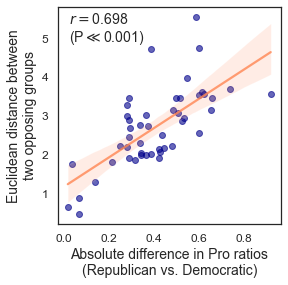

In [139]:
pcc = pearsonr(pro_ratio['Absolute_difference'], pro_ratio['Euclidean_distance'])[0]
pvalue = pearsonr(pro_ratio['Absolute_difference'], pro_ratio['Euclidean_distance'])[1]

plt.figure(figsize=(4,4))
sns.regplot(x='Absolute_difference', y='Euclidean_distance', data=pro_ratio, scatter_kws={'color':'darkblue','alpha':0.6}, line_kws={'color':'#FF8653', 'alpha':0.8})
plt.xlabel('Absolute difference in Pro ratios\n(Republican vs. Democratic)', fontsize=14)
plt.ylabel('Euclidean distance between\ntwo opposing groups', fontsize=14)
plt.text(x=0.02, y=4.9, s=r'$r=$%.3f'%(pcc) + '\n(P$\ll$0.001)', fontsize=14)
plt.legend(frameon=False, loc=2, fontsize=13)
#plt.savefig('../fig/Issue_vector/ddo_issue_pro_ratio_correlation_scatter.pdf', transparent=True, bbox_inches='tight')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


In [140]:
pvalue

3.5213194003640794e-08

In [141]:
pro_ratio.sort_values(by='Absolute_difference', ascending=False)

Republican  Democratic  N_Rep  N_Dem  Difference  \
Social_issue                                                                  
Barack Obama                 0.041719    0.961420    791    648   -0.919700   
National Health Care         0.211558    0.948328    969    987   -0.736770   
Occupy Movement              0.084699    0.745098    366    255   -0.660399   
Welfare                      0.245781    0.900755    948    927   -0.654975   
Socialism                    0.046774    0.668539    620    356   -0.621765   
Progressive Tax              0.195846    0.809370    674    619   -0.613524   
Abortion                     0.151311    0.753935   1335   1207   -0.602625   
Redistribution               0.104623    0.707207    411    222   -0.602584   
Stimulus Spending            0.198830    0.800000    342    245   -0.601170   
Gay Marriage                 0.306338    0.894647   1136   1177   -0.588309   
Global Warming Exists        0.384250    0.929211   1054   1116   -0.544961   
Border Fence                 0.843018    0.309698   1153    959    0.533321   
European Union               0.361582    0.888235    354    340   -0.526653   
Social Programs              0.453804    0.971463    736    841   -0.517658   
Labor Union                  0.402130    0.907595    751    790   -0.505464   
Iran-Iraq War                0.563830    0.065126    846    952    0.498704   
Medicaid & Medicare          0.450721    0.934021    832    970   -0.483299   
Gun Rights                   0.932000    0.451777   1250    985    0.480223   
War in Afghanistan           0.689146    0.243902    949    984    0.445244   
War on Terror                0.833945    0.396186   1090    944    0.437759   
Death Penalty                0.758647    0.333620   1301   1163    0.425027   
Flat Tax                     0.679470    0.255255    755    666    0.424215   
Affirmative Action           0.178530    0.600817    857    734   -0.422288   
Euthanasia                   0.394537    0.782473    659    639   -0.387935   
Military Intervention        0.735169    0.350000    472    360    0.385169   
Estate Tax                   0.194631    0.566122    745    673   -0.371491   
Torture                      0.459902    0.096085    611    562    0.363816   
Civil Unions                 0.487531    0.850521    802    863   -0.362990   
Minimum Wage                 0.556584    0.897512    972   1005   -0.340928   
Globalization                0.529255    0.869697    376    330   -0.340442   
Social Security              0.598632    0.938312    877    924   -0.339680   
Gold Standard                0.687500    0.350943    320    265    0.336557   
Federal Reserve              0.483965    0.800000    343    255   -0.316035   
Animal Rights                0.644670    0.937898    591    628   -0.293228   
United Nations               0.636266    0.926559    932    994   -0.290293   
Environmental Protection     0.679381    0.968226    970   1133   -0.288845   
Electoral College            0.600332    0.313278    603    482    0.287054   
Legalized Prostitution       0.284298    0.571111    605    450   -0.286814   
Racial Profiling             0.447164    0.165006    899    903    0.282158   
Medical Marijuana            0.558140    0.839201   1075   1051   -0.281061   
Drug Legalization            0.278689    0.556595   1220   1069   -0.277906   
Capitalism                   0.933148    0.685714    718    455    0.247433   
Homeschooling                0.774597    0.560680    559    412    0.213918   
National Retail Sales Tax    0.413490    0.551724    682    580   -0.138234   
Smoking Ban                  0.530534    0.598936   1048    940   -0.068402   
Free Trade                   0.865784    0.798343    529    362    0.067442   
Internet Censorship          0.173139    0.138577    618    534    0.034562   
Term Limits                  0.802757    0.786141    943    837    0.016616   

                           Absolute_difference  Euclidean_distance  
Social_

## Belief prediction - three factors

In [20]:
def get_accuracy(y,y_hat):
    is_same = (y==y_hat)
    acc = sum(is_same)/len(is_same)
    return acc

def get_f1_score(y, y_hat):
    return f1_score(y, y_hat, average='macro')

In [21]:
data_indices = [0,1,2,3,4]
model_types = ['model_bert_ft', 'model_roberta-base_ft', 'model_bert', 'model_roberta-base']
model_labels = ['Finetuned BERT', 'Finetuned S-BERT', 'BERT', 'S-BERT'] 

model_type = model_types[1] #Focus on S-BERT        

df_samples = []

for data_idx in range(0,5):
    df_sample = pd.read_pickle("../dataset/DownstreamTask_Dataframe/downstream_results_data(%d)_model(%s).p"%(data_idx, model_type))
    df_samples.append(df_sample)
    

In [22]:
df_samples[0].head()

debate_key  \
1  .-Audis-are-junkers-except-to-rich-kids-with-l...   
2  ....-Former-Secretary-of-State-Madeleine-Albri...   
4                      .9-repeated-is-equal-to-1./1/   
5                            .99-is-equal-to-one./1/   
7         .999-repeating-is-equal-to-1-in-reality/1/   

                                        debate_title          username  \
1  . Audis are junkers, except to rich kids with ...       Max.Wallace   
2  ...."Former Secretary of State Madeleine Albri...   Lookingatissues   
4                         .9 repeated is equal to 1.        cowpie1998   
5                               .99 is equal to one.  SweetCrackerJack   
7            .999 repeating is equal to 1 in reality            batman   

  debate_date position  is_belief  \
1  2014-09-04      Pro        1.0   
2  2017-01-30      Pro        1.0   
4  2011-04-07      Pro        1.0   
5  2013-12-24      Pro        1.0   
7  2008-01-05      Pro        1.0   

                                    belief_statement  votelen  \
1  I agree with the following: . Audis are junker...      141   
2  I agree with the following: ...."Former Secret...       29   
4  I agree with the following: .9 repeated is equ...        1   
5   I agree with the following: .99 is equal to one.        6   
7  I agree with the following: .999 repeating is ...        4   

   predicted_outcome  true_outcome      d_min      d_max      d_avg     d_rel  \
1               True          True  20.327671  36.096668  28.212170  0.775741   
2               True          True  19.105055  37.939125  28.522091  0.985816   
4               True          True  33.669613  37.313911  35.491760  0.108237   
5              False          True  28.006863  31.512686  29.759773  0.125177   
7               True          True  27.081041  30.997705  29.039373  0.144628   

   majority_pred  random_pred  
1           True            0  
2           True            1  
4           True            1  
5           True            0  
7           True            0

In [23]:
### Debate category information 

In [24]:
with open('../dataset/debatekey2category_dict.p', 'rb') as f:
    debatekey2category = pickle.load(f)

In [25]:
from collections import Counter
cat_count = pd.Series(Counter(debatekey2category.values()))

In [26]:
for df_ in df_samples:
    df_['Category'] = df_['debate_key'].map(debatekey2category)

## Precition Score over debate category (fig-5d)

In [27]:
#Consider debate categories that appears more than 1000 times. 
top_category = cat_count[cat_count >= 1000]
top_category

Miscellaneous     6277
Politics         15278
Society           7867
Science           4583
Education         5568
Technology        1655
Entertainment     4157
Religion         10287
Economics         1899
Arts              1163
Philosophy        5246
Funny             1394
Health            3182
People            2744
Games             1758
Sports            2267
dtype: int64

In [28]:
category2f1scores = defaultdict(list)
category2avg_drel = defaultdict(list)

In [29]:
for i in range(5):
    for g, df_ in df_samples[i].groupby('Category'):
        if g in top_category:
            category2f1scores[g].append(get_f1_score(df_['true_outcome'], df_['predicted_outcome']))
            category2avg_drel[g].append(df_['d_rel'].mean())

In [30]:
categories = []
f1avgs = []
f1stds = []
avg_drel = []

for c in category2f1scores:
    categories.append(c)
    f1avgs.append(np.mean(category2f1scores[c]))
    f1stds.append(np.std(category2f1scores[c]))
    avg_drel.append(np.mean(category2avg_drel[c]))

In [31]:
category2f1scores

defaultdict(list,
            {'Arts': [0.522336227308603,
              0.5536034173901061,
              0.5058482225087493,
              0.5589416896235078,
              0.5908316291751874],
             'Economics': [0.5387024279753021,
              0.5491326306543698,
              0.5407378982399684,
              0.5739253760681775,
              0.5760984409225616],
             'Education': [0.5338478589522289,
              0.5570336017305914,
              0.5535210748615361,
              0.5279503105590062,
              0.5442299644277045],
             'Entertainment': [0.5377428135232317,
              0.5364811388631926,
              0.5434005740923634,
              0.5384419885054,
              0.5319639201833597],
             'Funny': [0.5247162485065711,
              0.5120519093713435,
              0.516845755383364,
              0.5622236958443855,
              0.49182160651354967],
             'Games': [0.5580538864120953,
              0.492710106794

In [32]:
dat_f1 = pd.DataFrame({'Category':categories, 'Average':f1avgs, 'Std':f1stds, 'd_rel':avg_drel})
dat_f1 = dat_f1.sort_values(by='Average', ascending=False)
dat_f1

Category   Average       Std     d_rel
11       Religion  0.652771  0.009220  0.328671
9      Philosophy  0.604588  0.015636  0.269031
12        Science  0.601581  0.005596  0.271241
10       Politics  0.567292  0.013683  0.214267
13        Society  0.566057  0.021517  0.209129
6          Health  0.563864  0.017882  0.206483
8          People  0.562121  0.017280  0.234866
1       Economics  0.555719  0.016150  0.214400
0            Arts  0.546312  0.029688  0.211396
2       Education  0.543317  0.011126  0.208081
3   Entertainment  0.537606  0.003671  0.177009
7   Miscellaneous  0.530429  0.017784  0.182392
14         Sports  0.529642  0.008509  0.191913
15     Technology  0.526949  0.021573  0.189950
4           Funny  0.521532  0.023067  0.198985
5           Games  0.521477  0.024385  0.215019

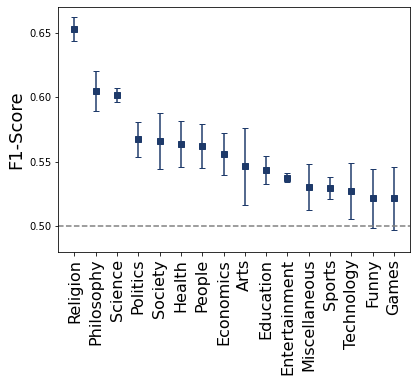

In [33]:
fig, ax = plt.subplots(figsize=(6.3,4.5))

plt.errorbar(x=np.arange(len(dat_f1)), y=dat_f1['Average'], fmt='s', yerr=dat_f1['Std'], capsize=3,
        color='#1E3A6A')

plt.ylim(0.48,0.67)
plt.xticks(np.arange(len(dat_f1)), list(dat_f1['Category']), rotation=90, fontsize=16)
plt.xlabel('')
plt.ylabel("F1-Score", fontsize=18)
plt.yticks([0.5,0.55,0.6,0.65])
plt.axhline(0.5, ls='--', color='gray')
#plt.savefig('../fig/downstream_results/category_vs_f1score_nobar.pdf', transparent=True, bbox_inches='tight')
plt.show()

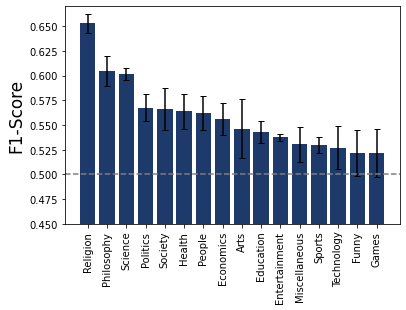

In [34]:
fig, ax = plt.subplots()
plt.bar(np.arange(len(dat_f1)), height=dat_f1['Average'], yerr=dat_f1['Std'], capsize=3,
        color='#1E3A6A', error_kw=dict(ecolor='k'))

plt.ylim(0.45,0.67)
plt.xticks(np.arange(len(dat_f1)), list(dat_f1['Category']), rotation=90)
plt.xlabel('')
plt.ylabel("F1-Score", fontsize=17)
plt.axhline(0.5, ls='--', color='gray')
#plt.savefig('../fig/downstream_results/category_vs_f1score.pdf', transparent=True, bbox_inches='tight')
plt.show()

In [35]:
from scipy import stats

corr = stats.pearsonr(dat_f1['d_rel'], dat_f1['Average'])

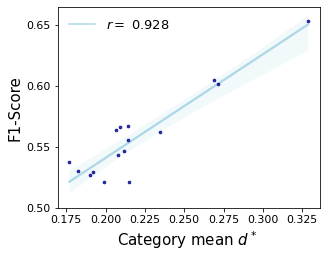

In [36]:
fig, ax = plt.subplots(figsize=(4.7,3.7) )

sns.regplot(data=dat_f1, x='d_rel', y='Average', 
            line_kws={'color':'lightblue'}, ax=ax, scatter=True, 
            scatter_kws={'s':7, 'color':'darkblue', 'alpha':0.8, 'zorder':10})

ax.plot([],[],label = r'$r =$ %.3f'%(corr[0]), color='lightblue')



#for i in range(len(dat_f1)):
#    ax.text(dat_f1['d_rel'].iloc[i],  dat_f1['Average'].iloc[i], dat_f1['Category'].iloc[i], fontsize=4, rotation=70)


plt.xlabel(r'Category mean $d^*$ ', fontsize=15)
plt.ylabel('F1-Score', fontsize=15)
plt.xticks(fontsize=11)
plt.yticks([0.5,0.55,0.6,0.65],fontsize=11)
plt.legend(frameon=False, loc=2, fontsize=13)

#plt.savefig('../fig/downstream_results/Downstream_score_vs_debate_category_dstar.pdf',transparent=True, bbox_inches='tight')
#plt.savefig('../fig/downstream_results/Downstream_score_vs_debate_category_dstar_withtext.pdf',transparent=True, bbox_inches='tight')
plt.show()

## Precition Score over distance (fig-5e-h)

In [38]:
df_ = df_samples[0]

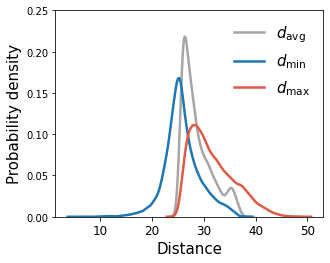

In [39]:
fig, ax = plt.subplots(figsize=(4.8,3.8))
sns.kdeplot(np.array(df_['d_avg']), color='gray', ax=ax, label=r'$d_{\mathrm{avg}}$', lw=2.5, alpha=0.7 )
sns.kdeplot(np.array(df_['d_min']), ax=ax, label=r'$d_{\mathrm{min}}$', lw=2.5, )
sns.kdeplot(np.array(df_['d_max']), color='#DE5B46', ax=ax, label=r'$d_{\mathrm{max}}$', lw=2.5 )
plt.xlabel('Distance', fontsize=15)
plt.ylabel('Probability density', fontsize=15)
plt.ylim(0,0.25)
plt.xticks(fontsize=12)
plt.legend(frameon=False, fontsize=15)
#plt.savefig('../fig/downstream_results/distance_distribution.pdf', transparent=True, bbox_inches='tight')
plt.show()

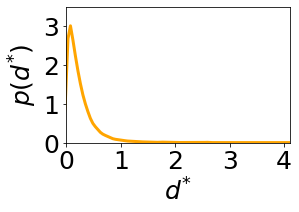

In [40]:
fig, ax = plt.subplots(figsize=(4,2.5))
sns.kdeplot(np.array(df_['d_rel']), color='orange', ax=ax, label=r'$\frac{d_{max}-d_{min}}{d_{min}}$', lw=3 )
plt.xlabel(r'$d^{*}$', fontsize=25)
plt.ylabel(r'$p(d^{*})$', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylim(0,3.5)
plt.xlim(0,4.1)
#plt.savefig('../fig/downstream_results/distance_distribution_(d_rel).pdf', transparent=True, bbox_inches='tight')
plt.show()


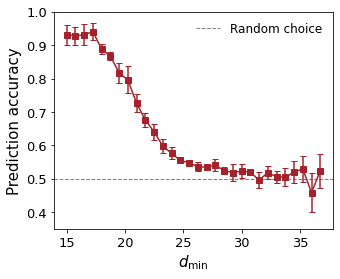

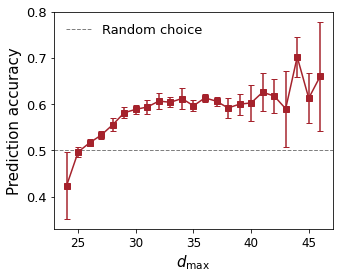

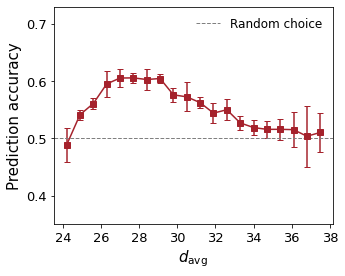

In [41]:
viridis_map = plt.cm.get_cmap('Reds')
color_values = np.linspace(0, 1, 5)
cmap = [viridis_map(color_val) for color_val in color_values]
mycolor = '#A5222C'


colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854']

#Min Distance  
plt.figure(figsize=(5,4))
f1_mat= []
acc_mat= []
window = .75
xs = np.arange(15,40,window)

for data_idx in range(5):
    df_ = df_samples[data_idx]
    x_list = []
    f1_list = []
    acc_list = []
    thres = 10
    
    for x1 in xs:
        df_temp = df_[(df_['d_min']>=x1) & (df_['d_min']<x1+window) ]
        if len(df_temp) < thres:
            x_list.append(np.NaN)
            f1_list.append(np.NaN)
            acc_list.append(np.NaN)
            continue

        x_list.append(x1)
        f1_list.append( f1_score(df_temp.true_outcome, df_temp.predicted_outcome, average='macro') ) 
        acc_list.append( np.mean(df_temp.true_outcome == df_temp.predicted_outcome))
    
    f1_mat.append(np.array(f1_list))
    acc_mat.append(np.array(acc_list))
    
f1_mat = np.array(f1_mat)
acc_mat = np.array(acc_mat)

err = np.std(f1_mat, axis=0)
acc_err = np.std(acc_mat, axis=0)

plt.axhline(.5,  ls='--', lw=1, color='gray', label='Random choice')        
#plt.errorbar(xs, f1_mat.mean(axis=0), yerr=err, ms=6, elinewidth=1.5, capsize=3, 
#             color=mycolor, fmt="-s", ecolor = mycolor)
plt.errorbar(xs, acc_mat.mean(axis=0), yerr=acc_err, ms=6, elinewidth=1.5, capsize=3, 
             color=mycolor, fmt="-s", ecolor = mycolor)


plt.xlabel(r"$d_{\mathrm{min}}$", fontsize=15)
#plt.ylabel('Average F1-score', fontsize=15)
plt.ylabel('Prediction accuracy', fontsize=15)
plt.xticks(np.arange(15,36,5), fontsize=13)
plt.yticks(fontsize=13)
plt.ylim(0.35, 1.0)
plt.legend(frameon=False, fontsize=12)
#plt.savefig('../fig/downstream_results/distance_vs_accuracy_(dmin).pdf',transparent=True, bbox_inches='tight')

##########################################################################################
#Max Distance  
plt.figure(figsize=(5,4))
window = 1
xs = np.arange(20, 50, window)
f1_mat= []
acc_mat = [] 

for data_idx in range(5):
    df_ = df_samples[data_idx]
    x_list = []
    f1_list = []
    acc_list = []
    thres = 10

    for x1 in xs:
        df_temp = df_[(df_['d_max']>=x1) & (df_['d_max']<x1+window) ]
        if len(df_temp) < thres:
            x_list.append(np.NaN)
            f1_list.append(np.NaN)
            acc_list.append(np.NaN)
            continue

        x_list.append(x1)
        f1_list.append( f1_score(df_temp.true_outcome, df_temp.predicted_outcome, average='macro') ) 
        acc_list.append( np.mean(df_temp.true_outcome == df_temp.predicted_outcome))
    
    f1_mat.append(np.array(f1_list))
    acc_mat.append(np.array(acc_list))
    #plt.plot(x_list, f1_list,  '-', lw=1, color='gray', alpha=0.2)#, label='Data %d'%(data_idx+1))

f1_mat = np.array(f1_mat)
acc_mat = np.array(acc_mat)
err = np.std(f1_mat, axis=0)
acc_err = np.std(acc_mat, axis=0)
plt.axhline(.5,  ls='--', lw=1, color='gray', label='Random choice')        
#plt.errorbar(xs, f1_mat.mean(axis=0), yerr=err, ms=6, elinewidth=1.5, capsize=3, 
#             color=mycolor, fmt="-s", ecolor = mycolor)
plt.errorbar(xs, acc_mat.mean(axis=0), yerr=acc_err, ms=6, elinewidth=1.5, capsize=3, 
             color=mycolor, fmt="-s", ecolor = mycolor)


plt.xlabel(r"$d_{\mathrm{max}}$", fontsize=15)
#plt.ylabel('Average F1-score', fontsize=15)
plt.ylabel('Prediction accuracy', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=13)
plt.legend(frameon=False, fontsize=13, loc=2)
#plt.savefig('../fig/downstream_results/distance_vs_accuracy_(dmax).pdf',transparent=True, bbox_inches='tight')

##########################################################################################
#Avg Distance  
plt.figure(figsize=(5,4))
window = .7
xs = np.arange(20, 40, window)
f1_mat= []
acc_mat = []

for data_idx in range(5):
    df_ = df_samples[data_idx]
    x_list = []
    f1_list = []
    acc_list = []
    thres = 10

    for x1 in xs:
        df_temp = df_[(df_['d_avg']>=x1) & (df_['d_avg']<x1+window) ]
        if len(df_temp) < thres:
            x_list.append(np.NaN)
            f1_list.append(np.NaN)
            acc_list.append(np.NaN)
            continue

        x_list.append(x1)
        f1_list.append( f1_score(df_temp.true_outcome, df_temp.predicted_outcome, average='macro') ) 
        acc_list.append( np.mean(df_temp.true_outcome == df_temp.predicted_outcome))

    f1_mat.append(np.array(f1_list))
    acc_mat.append(np.array(acc_list))
    #plt.plot(x_list, f1_list,  '-', lw=1, color='gray', alpha=0.2)#, label='Data %d'%(data_idx+1))

f1_mat = np.array(f1_mat)
acc_mat = np.array(acc_mat)
err = np.std(f1_mat, axis=0)
acc_err = np.std(acc_mat, axis=0)
#plt.errorbar(xs, f1_mat.mean(axis=0), yerr=err, ms=6, elinewidth=1.5, capsize=3, 
#             color=mycolor, fmt="-s", ecolor = mycolor)

plt.errorbar(xs, acc_mat.mean(axis=0), yerr=acc_err, ms=6, elinewidth=1.5, capsize=3, 
             color=mycolor, fmt="-s", ecolor = mycolor)

plt.axhline(.5,  ls='--', lw=1, color='gray', label='Random choice')        

plt.ylim(0.35, 0.73)
plt.xlabel(r"$d_{\mathrm{avg}}$", fontsize=15)
#plt.ylabel('Average F1-score', fontsize=15)
plt.ylabel('Prediction accuracy', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks([0.4,0.5,0.6,0.7], fontsize=13)
plt.legend(frameon=False, fontsize=12)
#plt.savefig('../fig/downstream_results/distance_vs_accuracy_(dmavg).pdf',transparent=True, bbox_inches='tight')

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


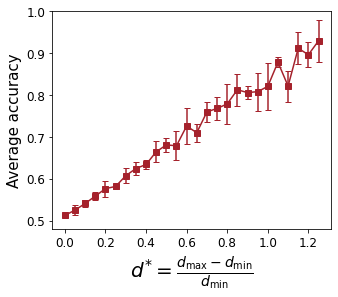

In [42]:
##########################################################################################
#Distance Function

plt.figure(figsize=(5,4))
window = .05
xs = np.arange(0, 1.3, window)
acc_mat= []

for data_idx in range(5):
    df_ = df_samples[data_idx]
    x_list = []
    acc_list = []
    thres = 10

    for x1 in xs:
        df_temp = df_[(df_['d_rel']>=x1) & (df_['d_rel']<x1+window) ]
        if len(df_temp) < thres:
            x_list.append(np.NaN)
            acc_list.append(np.NaN)
            continue

        x_list.append(x1)        
        acc_list.append( np.mean(df_temp.true_outcome == df_temp.predicted_outcome))
    
    acc_mat.append(np.array(acc_list))

acc_mat = np.array(acc_mat)
err = np.std(acc_mat, axis=0)
plt.errorbar(xs, acc_mat.mean(axis=0), yerr=err, ms=6, elinewidth=1.5, capsize=3, 
             color=mycolor, fmt="-s", ecolor = mycolor)

plt.ylim(0.48, 1.0)
plt.xlabel(r'$d^{*}=\frac{d_{\mathrm{max}}-d_{\mathrm{min}}}{d_{\mathrm{min}}}$', fontsize=20)
plt.ylabel('Average accuracy', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(frameon=False, fontsize=10)
#plt.savefig('../fig/downstream_results/distance_vs_accuracy_(d_rel).pdf',transparent=True, bbox_inches='tight')
plt.show()

### Heatmap - Joint distribution

Phase diagram
 - dmin : (15, 35)
 - dmax : (20, 45) 
 

In [44]:
x1 = 13 #dmin 
x2 = 40
y1 = 23 #dmax
y2 = 46
xwindow = .6
ywindow = .6

df_ = df_samples[0]
print(len(df_))
df_ = df_[ (df_['d_min'] > x1) & (df_['d_min'] < x2) ]
df_ = df_[ (df_['d_max'] > y1) & (df_['d_max'] < y2) ]
print(len(df_))

df_['xbin'] = ((df_['d_min'] - x1)/xwindow).astype(int)
df_['ybin'] = ((df_['d_max'] - y1)/ywindow).astype(int)

df_.head(1)

34091
33981


debate_key  \
1  .-Audis-are-junkers-except-to-rich-kids-with-l...   

                                        debate_title     username debate_date  \
1  . Audis are junkers, except to rich kids with ...  Max.Wallace  2014-09-04   

  position  is_belief                                   belief_statement  \
1      Pro        1.0  I agree with the following: . Audis are junker...   

   votelen  predicted_outcome  true_outcome      d_min      d_max     d_avg  \
1      141               True          True  20.327671  36.096668  28.21217   

      d_rel  majority_pred  random_pred Category  xbin  ybin  
1  0.775741           True            0     Cars    12    21

In [45]:
df_['correct_euc'] = df_['predicted_outcome']==df_['true_outcome']

In [46]:
L_x = int(np.ceil((x2-x1)/xwindow)) #dmin
L_y = int(np.ceil((y2-y1)/ywindow)) #dmax

true_map = np.zeros((L_y, L_x))
cnt_map = np.zeros((L_y, L_x))

for i in range(len(df_)):
    cnt_map[df_.iloc[i].ybin][df_.iloc[i].xbin] += 1
    
    if df_.iloc[i].correct_euc == True:
        true_map[df_.iloc[i].ybin][df_.iloc[i].xbin] += 1
    
print(true_map.shape)

(39, 45)


In [47]:
acc_map = true_map / cnt_map

for i in range(L_y):
    for j in range(L_x):
        if cnt_map[i][j] <= 5:
            acc_map[i][j] = 0

is_zero = acc_map == 0
acc_map[is_zero] = np.nan            

/var/folders/r8/jdw1p2tj6jn34wf676kcsw_r0000gn/T/ipykernel_34453/3910540346.py:1: RuntimeWarning: invalid value encountered in divide
  acc_map = true_map / cnt_map


In [48]:
xticks = np.arange(x1, x2, xwindow)
yticks = np.arange(y1, y2, ywindow)
xticks

array([13. , 13.6, 14.2, 14.8, 15.4, 16. , 16.6, 17.2, 17.8, 18.4, 19. ,
       19.6, 20.2, 20.8, 21.4, 22. , 22.6, 23.2, 23.8, 24.4, 25. , 25.6,
       26.2, 26.8, 27.4, 28. , 28.6, 29.2, 29.8, 30.4, 31. , 31.6, 32.2,
       32.8, 33.4, 34. , 34.6, 35.2, 35.8, 36.4, 37. , 37.6, 38.2, 38.8,
       39.4])

In [49]:
x_bins = []
x_vals = []

y_bins = []
y_vals = []

for e in np.arange(0, L_x, 5):
    x_bins.append(e)
    x_vals.append(int(x1+e*xwindow))
    
for e in np.arange(0, L_y, 5):
    y_bins.append(e)
    y_vals.append(int(y1+e*ywindow))    

print(x_bins)
print(x_vals)

[0, 5, 10, 15, 20, 25, 30, 35, 40]
[13, 16, 19, 22, 25, 28, 31, 34, 37]


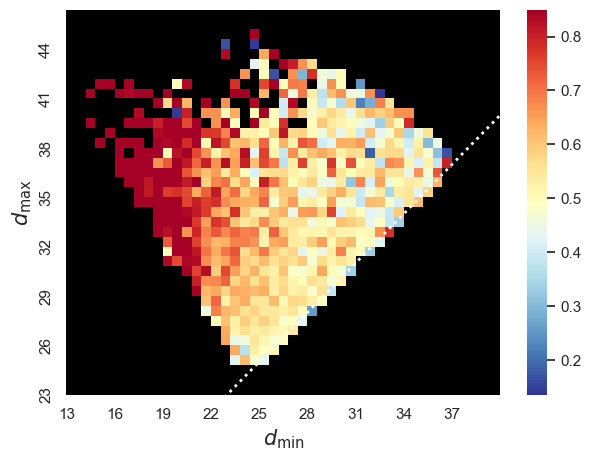

In [50]:
sns.reset_defaults()

fig = plt.figure(figsize=(7,5))
sns.set(rc={'axes.facecolor':'black', "grid.color": ".2", "grid.linestyle": ":"})
ax = sns.heatmap(acc_map, vmin=0.85, vmax=.15, cmap='RdYlBu_r')

t = np.arange(10,60)
ax.plot(t, t*(xwindow/ywindow)-(y1-x1)/ywindow, lw=2, color='w', ls=':')
ax.plot(t, -(xwindow/ywindow)*t + (25-x1-y1)/ywindow, lw=2, color='y', ls='--')
ax.grid(False)
ax.invert_yaxis()
plt.xlabel(r'$d_{\mathrm{min}}$', fontsize=15)
plt.ylabel(r'$d_{\mathrm{max}}$', fontsize=15)
plt.xticks(x_bins, x_vals) #matrix heatmap (x, y converted)
plt.yticks(y_bins, y_vals)
#plt.title('Average accuracy')
#plt.savefig('../fig/downstream_results/dmin_dmax_heatmap.png', dpi=200, bbox_inches='tight')
plt.show()

### d* vs Accuracy (F1 score) - Political party and Religion dependency

In [52]:
with open('../dataset/User_survey/issue2groups(useridx).p', 'rb') as f:
    category2groups = pickle.load(f)
    
with open('../dataset/User_survey/idx2user.p', 'rb') as f:
    idx2user = pickle.load(f)    

In [53]:
user2party = {}
user2religion = {}

for party in category2groups['Political party']:
    for user_idx in category2groups['Political party'][party]:
        user2party[idx2user[user_idx]] = party

for t in category2groups['Religion']:
    for user_idx in category2groups['Religion'][t]:
        user2religion[idx2user[user_idx]] = t

In [54]:
for i in range(5):
    df_samples[i]['Party'] = df_samples[i]['username'].map(user2party)
    df_samples[i]['Religion'] = df_samples[i]['username'].map(user2religion)

In [ ]:
#for i in range(5):
#    df_samples[i].to_pickle('../dataset/05_Traindata_with_Userinfo/df_train_finetunedSBERT_with_userinfo_idx%d.p'%(i))

### d*  vs acc for Political parties

In [55]:
rep = []
dem = []
for data_idx in range(5):
    df_ = df_samples[data_idx] #dem:1, rep:2
    df_rep = df_[df_['Party']=='Republican']
    df_dem = df_[df_['Party']=='Democratic']
    
    print(len(df_rep.username.unique()), len(df_dem.username.unique()))
    rep.append(len(df_rep.username.unique()))
    dem.append(len(df_dem.username.unique()))
    
print("#dem:%d\n#rep:%d"%(np.mean(dem), np.mean(rep)))

734 682
756 693
711 685
704 670
723 673
#dem:680
#rep:725


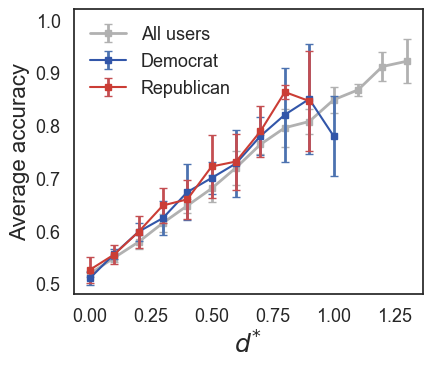

In [56]:
sns.set_style('white')
##########################################################################################
#새로운 거리 함수 Distance Function 1

plt.figure(figsize=(4.5,3.7))

window = .1
xs = np.arange(0, 1.4, window)

#all
f1_mat = []
acc_mat = []

for data_idx in range(5):
    df_ = df_samples[data_idx]
    x_list = []
    f1_list = []
    acc_list = []
    thres = 5

    for x1 in xs:
        df_temp = df_[(df_['d_rel']>=x1) & (df_['d_rel']<x1+window) ]
        if len(df_temp) < thres:
            x_list.append(np.NaN)
            f1_list.append(np.NaN)
            acc_list.append(np.NaN)
            continue

        x_list.append(x1)        
        f1_list.append( f1_score(df_temp.predicted_outcome, df_temp.true_outcome, average='macro') ) 
        acc_list.append( np.mean(df_temp.predicted_outcome == df_temp.true_outcome))
    
    f1_mat.append(np.array(f1_list))
    acc_mat.append(np.array(acc_list))
    #plt.plot(x_list, f1_list,  '-', lw=1, color='gray', alpha=0.2)#, label='Data %d'%(data_idx+1))

#Average
f1_mat = np.array(f1_mat)
acc_mat = np.array(acc_mat)
err = np.std(f1_mat, axis=0)
err_acc = np.std(acc_mat, axis=0)
#plt.errorbar(xs, f1_mat.mean(axis=0), yerr=err, ms=6, lw=3, elinewidth=2, capsize=3,
#             color='#B1B1B1', fmt="o-", ecolor = "#B1B1B1", zorder=0, label='All users')
plt.errorbar(xs, acc_mat.mean(axis=0), yerr=err_acc, ms=5, lw=2, elinewidth=2, capsize=3,
             color='#B1B1B1', fmt="s-", ecolor = "#B1B1B1", zorder=0, label='All users')




#Democratic
f1_mat_dem= []
acc_mat_dem= []

for data_idx in range(5):
    df_ = df_samples[data_idx]
    df_ = df_[df_['Party']=='Democratic']
    x_list = []
    f1_list = []
    acc_list = []
    thres = 5

    for x1 in xs:
        df_temp = df_[(df_['d_rel']>=x1) & (df_['d_rel']<x1+window) ]
        if len(df_temp) < thres:
            x_list.append(np.NaN)
            f1_list.append(np.NaN)
            acc_list.append(np.NaN)
            continue

        x_list.append(x1)        
        f1_list.append( f1_score(df_temp.true_outcome, df_temp.predicted_outcome, average='macro') ) 
        acc_list.append( np.mean(df_temp.true_outcome == df_temp.predicted_outcome))
    
    f1_mat_dem.append(np.array(f1_list))
    acc_mat_dem.append(np.array(acc_list))


f1_mat_dem = np.array(f1_mat_dem)
err_dem = np.std(f1_mat_dem, axis=0)
acc_mat_dem = np.array(acc_mat_dem)
err_acc_dem = np.std(acc_mat_dem, axis=0)

#plt.errorbar(xs, f1_mat_dem.mean(axis=0), yerr=err_dem, ms=7, 
#             elinewidth=2, capsize=3, color='b', fmt="-s", ecolor = "b", label='Democrat')

plt.errorbar(xs, acc_mat_dem.mean(axis=0), yerr=err_acc_dem, ms=5, 
             elinewidth=2, capsize=3, color='#3256A9', fmt="-s", ecolor = "b", label='Democrat')


#Republican
f1_mat_rep= []
acc_mat_rep= []

for data_idx in range(5):
    df_ = df_samples[data_idx]
    df_ = df_[df_['Party']=='Republican']
    x_list = []
    f1_list = []
    acc_list = []
    thres = 5

    for x1 in xs:
        df_temp = df_[(df_['d_rel']>=x1) & (df_['d_rel']<x1+window) ]
        if len(df_temp) < thres:
            x_list.append(np.NaN)
            f1_list.append(np.NaN)
            acc_list.append(np.NaN)
            continue

        x_list.append(x1)        
        f1_list.append( f1_score(df_temp.true_outcome, df_temp.predicted_outcome, average='macro') ) 
        acc_list.append( np.mean(df_temp.true_outcome == df_temp.predicted_outcome))
    
    f1_mat_rep.append(np.array(f1_list))
    acc_mat_rep.append(np.array(acc_list))


f1_mat_rep = np.array(f1_mat_rep)
err_rep = np.std(f1_mat_rep, axis=0)
#plt.errorbar(xs, f1_mat_rep.mean(axis=0), yerr=err_rep, ms=7, elinewidth=2, 
#             capsize=3, color='r', fmt="-s", ecolor = "r", label='Republican')

acc_mat_rep = np.array(acc_mat_rep)
err_acc_rep = np.std(acc_mat_rep, axis=0)
plt.errorbar(xs, acc_mat_rep.mean(axis=0), yerr=err_acc_rep, ms=5, elinewidth=2, 
             capsize=3, color='#CB3D35', fmt="-s", ecolor = "r", label='Republican')




plt.ylim(0.48, 1.02)
plt.xlabel(r'$d^{*}$', fontsize=18)
plt.ylabel('Average accuracy', fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(frameon=False, fontsize=13)
#plt.savefig('../fig/downstream_results/drel_vs_Acc_politicalparty.pdf',transparent=True, bbox_inches='tight')
plt.show()

In [57]:
from scipy import stats
#F1-score of Rep, Dem is not significant under t-test for the means of two independent samples
for i in range(len(acc_mat_dem[1,])):
    print(stats.ttest_ind(acc_mat_dem[:,i],  acc_mat_rep[:,i]))

TtestResult(statistic=-1.168964514851045, pvalue=0.2760676571547157, df=8.0)
TtestResult(statistic=0.0984687536975112, pvalue=0.923982634475991, df=8.0)
TtestResult(statistic=0.009761927475192656, pvalue=0.9924502793023693, df=8.0)
TtestResult(statistic=-1.0321401832167454, pvalue=0.33219732738522617, df=8.0)
TtestResult(statistic=0.4230861493218488, pvalue=0.6833763775755554, df=8.0)
TtestResult(statistic=-0.6568152605139032, pvalue=0.529736901409368, df=8.0)
TtestResult(statistic=-0.08834823806350192, pvalue=0.9317714844749794, df=8.0)
TtestResult(statistic=-0.2953112189288541, pvalue=0.7752754242738995, df=8.0)
TtestResult(statistic=-0.9591250658597649, pvalue=0.36558172349499735, df=8.0)
TtestResult(statistic=0.05354070694580606, pvalue=0.9586139654218245, df=8.0)
TtestResult(statistic=nan, pvalue=nan, df=nan)
TtestResult(statistic=nan, pvalue=nan, df=nan)
TtestResult(statistic=nan, pvalue=nan, df=nan)
TtestResult(statistic=nan, pvalue=nan, df=nan)


### d*  vs acc for Political parties

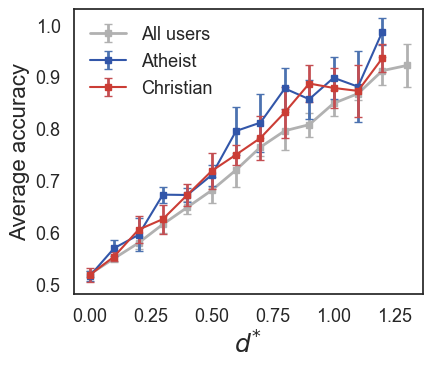

In [58]:
sns.set_style('white')
##########################################################################################
#새로운 거리 함수 Distance Function 1

plt.figure(figsize=(4.5,3.7))

window = .1
xs = np.arange(0, 1.4, window)

#all
f1_mat = []
acc_mat = []

for data_idx in range(5):
    df_ = df_samples[data_idx]
    x_list = []
    f1_list = []
    acc_list = []
    thres = 5

    for x1 in xs:
        df_temp = df_[(df_['d_rel']>=x1) & (df_['d_rel']<x1+window) ]
        if len(df_temp) < thres:
            x_list.append(np.NaN)
            f1_list.append(np.NaN)
            acc_list.append(np.NaN)
            continue

        x_list.append(x1)        
        f1_list.append( f1_score(df_temp.predicted_outcome, df_temp.true_outcome, average='macro') ) 
        acc_list.append( np.mean(df_temp.predicted_outcome == df_temp.true_outcome))
    
    f1_mat.append(np.array(f1_list))
    acc_mat.append(np.array(acc_list))
    #plt.plot(x_list, f1_list,  '-', lw=1, color='gray', alpha=0.2)#, label='Data %d'%(data_idx+1))

#Average
f1_mat = np.array(f1_mat)
acc_mat = np.array(acc_mat)
err = np.std(f1_mat, axis=0)
err_acc = np.std(acc_mat, axis=0)
#plt.errorbar(xs, f1_mat.mean(axis=0), yerr=err, ms=6, lw=3, elinewidth=2, capsize=3,
#             color='#B1B1B1', fmt="o-", ecolor = "#B1B1B1", zorder=0, label='All users')
plt.errorbar(xs, acc_mat.mean(axis=0), yerr=err_acc, ms=5, lw=2, elinewidth=2, capsize=3,
             color='#B1B1B1', fmt="s-", ecolor = "#B1B1B1", zorder=0, label='All users')




#Democratic
f1_mat_dem= []
acc_mat_dem= []

for data_idx in range(5):
    df_ = df_samples[data_idx]
    df_ = df_[df_['Religion']=='Atheist']
    x_list = []
    f1_list = []
    acc_list = []
    thres = 5

    for x1 in xs:
        df_temp = df_[(df_['d_rel']>=x1) & (df_['d_rel']<x1+window) ]
        if len(df_temp) < thres:
            x_list.append(np.NaN)
            f1_list.append(np.NaN)
            acc_list.append(np.NaN)
            continue

        x_list.append(x1)        
        f1_list.append( f1_score(df_temp.true_outcome, df_temp.predicted_outcome, average='macro') ) 
        acc_list.append( np.mean(df_temp.true_outcome == df_temp.predicted_outcome))
    
    f1_mat_dem.append(np.array(f1_list))
    acc_mat_dem.append(np.array(acc_list))


f1_mat_dem = np.array(f1_mat_dem)
err_dem = np.std(f1_mat_dem, axis=0)
acc_mat_dem = np.array(acc_mat_dem)
err_acc_dem = np.std(acc_mat_dem, axis=0)

#plt.errorbar(xs, f1_mat_dem.mean(axis=0), yerr=err_dem, ms=7, 
#             elinewidth=2, capsize=3, color='b', fmt="-s", ecolor = "b", label='Democrat')

plt.errorbar(xs, acc_mat_dem.mean(axis=0), yerr=err_acc_dem, ms=5, 
             elinewidth=2, capsize=3, color='#3256A9', fmt="-s", ecolor = "b", label='Atheist')


#Republican
f1_mat_rep= []
acc_mat_rep= []

for data_idx in range(5):
    df_ = df_samples[data_idx]
    df_ = df_[df_['Religion']=='Christian']
    x_list = []
    f1_list = []
    acc_list = []
    thres = 5

    for x1 in xs:
        df_temp = df_[(df_['d_rel']>=x1) & (df_['d_rel']<x1+window) ]
        if len(df_temp) < thres:
            x_list.append(np.NaN)
            f1_list.append(np.NaN)
            acc_list.append(np.NaN)
            continue

        x_list.append(x1)        
        f1_list.append( f1_score(df_temp.true_outcome, df_temp.predicted_outcome, average='macro') ) 
        acc_list.append( np.mean(df_temp.true_outcome == df_temp.predicted_outcome))
    
    f1_mat_rep.append(np.array(f1_list))
    acc_mat_rep.append(np.array(acc_list))


f1_mat_rep = np.array(f1_mat_rep)
err_rep = np.std(f1_mat_rep, axis=0) 
#plt.errorbar(xs, f1_mat_rep.mean(axis=0), yerr=err_rep, ms=7, elinewidth=2, 
#             capsize=3, color='r', fmt="-s", ecolor = "r", label='Republican')

acc_mat_rep = np.array(acc_mat_rep)
err_acc_rep = np.std(acc_mat_rep, axis=0)
plt.errorbar(xs, acc_mat_rep.mean(axis=0), yerr=err_acc_rep, ms=5, elinewidth=2, 
             capsize=3, color='#CB3D35', fmt="-s", ecolor = "r", label='Christian')




plt.ylim(0.48, 1.03)
plt.xlabel(r'$d^{*}$', fontsize=18)
plt.ylabel('Average accuracy', fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(frameon=False, fontsize=13)
#plt.savefig('../fig/downstream_results/drel_vs_Acc_Religion.pdf',transparent=True, bbox_inches='tight')
plt.show()

In [59]:
#F1-score of Rep, Dem is not significant under t-test for the means of two independent samples
for i in range(len(acc_mat_dem[1,])):
    print(stats.ttest_ind(acc_mat_dem[:,i],  acc_mat_rep[:,i]))

TtestResult(statistic=-0.24019254468055246, pvalue=0.8162213858445527, df=8.0)
TtestResult(statistic=1.8177617675419926, pvalue=0.10661677169555449, df=8.0)
TtestResult(statistic=-0.4855737196569009, pvalue=0.6402885303634784, df=8.0)
TtestResult(statistic=2.9583488734835903, pvalue=0.018192053196082535, df=8.0)
TtestResult(statistic=-0.0117626667925951, pvalue=0.9909030125333649, df=8.0)
TtestResult(statistic=-0.4040772726469718, pvalue=0.6967425959840785, df=8.0)
TtestResult(statistic=1.826149404218326, pvalue=0.10525619367735596, df=8.0)
TtestResult(statistic=0.8460872183293999, pvalue=0.42208872603042746, df=8.0)
TtestResult(statistic=1.438318749416431, pvalue=0.1882896207470391, df=8.0)
TtestResult(statistic=-1.178681385459015, pvalue=0.27239171624994263, df=8.0)
TtestResult(statistic=0.6998964524933923, pvalue=0.5038323406231535, df=8.0)
TtestResult(statistic=0.19205732261355543, pvalue=0.8524827819263898, df=8.0)
TtestResult(statistic=2.6810265964785085, pvalue=0.027881610520853